<H2> Imports </h2>

In [7]:
import cv2
import os
import math
import json
import gc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from PIL import Image
import numpy as np
import morphsnakes as ms

from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

import keras_tuner as kt
from scikeras.wrappers import KerasClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import precision_score, recall_score,  f1_score 
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

<h2>Constants & Utils</h2>

In [8]:
metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"
input_shape=(224,224)
batch_size=16

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
def open_image(image_path):
        # Load the image using Pillow
    pil_img = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)
    img_array = np.array(pil_img)
    return img_array

def show_image(img_array):
    if(img_array.shape[2]== 1):
        plt.imshow(img_array, cmap='gray')
    else:
        plt.imshow(img_array)
    plt.axis('off')
    plt.show()

Initially, each image in the dataset is of size 480x640 with 3 channels.

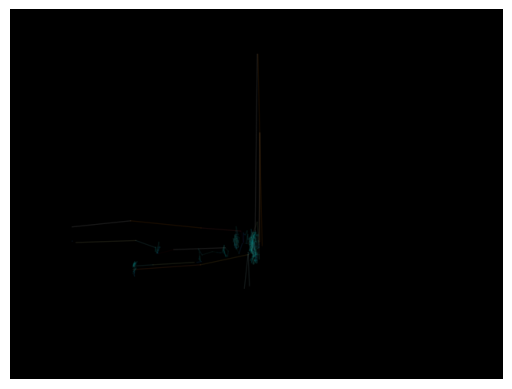

(480, 640, 3)


In [11]:
img_array = open_image(image_dir+"TCImages/TC001_39.png")
show_image(img_array)
print(img_array.shape)

In [12]:
def get_data_and_labels(dataset):
    """
    Extracts data and labels from a TensorFlow dataset.
    
    Args:
        dataset (tf.data.Dataset): The dataset to extract data and labels from.
        
    Returns:
        Tuple of (data, labels), where:
        - data is a NumPy array of features.
        - labels is a NumPy array of labels.
    """
    data = []
    labels = []
    dataset = dataset.unbatch()
    
    for features, label in dataset:
        data.append(features.numpy())
        labels.append(label.numpy())
    
    # Convert lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels


In [13]:
def get_batch_as_tensor(concatenated_dataset):
    data_list = []
    labels_list = []

    # Iterate over the dataset and collect data and labels
    for data, labels in concatenated_dataset:

        if data.ndim == 4 and data.shape[0] == 1:  # If shape is (1, H, W, C)
            data = np.squeeze(data, axis=0)

        # Append the current batch's data and labels to the lists
        data_list.append(data)  # Convert TensorFlow tensors to NumPy arrays
        labels_list.append(labels)

    # Concatenate all batches into a single array
    combined_data = np.array(data_list)  # Concatenate data along the sample axis (N)
    combined_labels = np.array(labels_list)  # Concatenate labels similarly

    # Ensure the data has the shape (N, H, W, C)
    return combined_data, combined_labels

In [14]:
# One hot encoding
class_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["TC", "TS"]),
        values=tf.constant([0, 1])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode(data, label):
    num_classes = 2  # Adjust this to the actual number of classes
    # Map string labels to integers
    
    label = class_mapping.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label

In [15]:
# One hot encoding
class_mapping_severity = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["Non-Autistic", "Mild to Moderate Autism", "Severe Autism", "Invalid Score"]),
        values=tf.constant([0, 1,2,3])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode_severity(data, label):
    num_classes = 4  # Adjust this to the actual number of classes
    # Map string labels to integers
    
    label = class_mapping_severity.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label

In [16]:
def plot_training_history(history, model_name="Model"):
    """
    Plots training and validation accuracy and loss for a given training history side by side.
    
    Args:
        history: Keras training history object.
        model_name: Name of the model (string) for labeling purposes.
    """
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training and validation accuracy
    axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
    axes[0].plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    axes[0].set_title(f'Training and Validation Accuracy ({model_name})')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid()
    
    # Plot training and validation loss
    axes[1].plot(epochs, loss, 'b', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[1].set_title(f'Training and Validation Loss ({model_name})')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()
    
    # Show the combined plots
    plt.tight_layout()
    plt.show()

In [80]:
def load_metadata_json(metadata_path):
    """
    Load metadata from a JSON file.
    Args:
        metadata_path (str): Path to the metadata file (JSON format).
    Returns:
        list: A list of dictionaries with metadata.
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata


def match_metadata_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages']

    for entry in metadata_merged:
        # Extract filename, label, and metadata features
        filename = entry['File']
        participant_id = entry['ParticipantID']
        age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # Determine the label
        label = "TC" if math.isnan(cars_score) else "TS"

        # Determine the image path
        subdir = 'TCImages' if label == "TC" else 'TSImages'
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists

        if os.path.exists(image_path):
            
            img_array = open_image(image_path)
            
            data.append(img_array)

            # Collect label and metadata features
            labels.append(label)
            metadata_features.append(
                #'CARS': 
                cars_score
                # 'ParticipantID': participant_id,
                # 'Age': age,
                # 'Gender': gender,
            )
        else:
            print(f"Warning: Image {filename} not found!")

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    # metadata_features_array = np.array([
        
    #         feature['CARS']
    #         # float(feature['ParticipantID']),
    #         # feature['Age'],
    #         # hash(feature['Gender']) if feature['Gender'] is not None else 0
        
    #     #for feature in metadata_features
    # ]).astype('float32')

    metadata_features_array = np.array(metadata_features)

    return data, labels, metadata_features_array


In [18]:
def interpret_cars_score(cars_score):
    """Interpret the CARS score based on the given ranges."""
    if 15 <= cars_score <= 29.5:
        return 'Non-Autistic' , 'TSImages'
    elif 30 <= cars_score <= 36.5:
        return 'Mild to Moderate Autism', 'TSImages'
    elif 37 <= cars_score <= 60:
        return 'Severe Autism', 'TSImages'
    else:
        return 'Invalid Score', 'TCImages'

In [19]:
def match_cars_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages'] 

    for entry in metadata_merged:
        # Extract metadata
        filename = entry['File']
        participant_id = entry['ParticipantID']
        age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # Interpret the CARS score
        cars_interpretation, subdir = interpret_cars_score(cars_score)

        # Determine the image path
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists
        if os.path.exists(image_path):
            
            img_array = open_image(image_path)
            if img_array is not None:
                data.append(img_array)

                # Collect labels and metadata features
                labels.append(cars_interpretation)
                metadata_features.append({
                    'ParticipantID': participant_id,
                    'Age': age,
                    'Gender': gender,
                })
        else:
            print(f"Warning: Image {filename} not found!")
            print(image_path)

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    metadata_features_array = np.array([
        [
            float(feature['ParticipantID']),
            feature['Age'],
            hash(feature['Gender']) if feature['Gender'] is not None else 0
        ]
        for feature in metadata_features
    ]).astype('float32')

    return np.array(data), labels, metadata_features_array

In [20]:
class KerasClassifierCompatible(KerasClassifier, BaseEstimator, ClassifierMixin):
    def __sklearn_tags__(self):
        return {
            "estimator_type": "classifier",
            "requires_positive_X": False,
            "no_validation": True,
        }

In [21]:
def calculate_f1_score(y_true_labels, y_pred_labels):
    # Convert one-hot encoded labels to single-label format (0 or 1)
    y_true = np.argmax(y_true_labels, axis=1)  # Converts [[1, 0], [0, 1]] -> [0, 1]
    y_pred = np.argmax(y_pred_labels, axis=1)  # Same conversion for predictions

    # Compute precision and recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')

In [22]:
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

In [23]:
def save_dataset(dataset, dataset_name):
    # Initialize lists to store dataset elements (features, labels)
    features_list = []
    labels_list = []

    # Iterate through the dataset and collect the elements
    for features, labels in dataset:
        features_list.append(features.numpy())  # Convert tensors to NumPy
        labels_list.append(labels.numpy())

    # Save as .npy files
    np.save(f"{dataset_name}_features.npy", np.array(features_list))
    np.save(f"{dataset_name}_labels.npy", np.array(labels_list))
    print(f"Dataset saved as {dataset_name}_features.npy and {dataset_name}_labels.npy")

def load_dataset(dataset_name):
    # Load the saved NumPy arrays
    features = np.load(f"{dataset_name}_features.npy",allow_pickle=True)
    labels = np.load(f"{dataset_name}_labels.npy",allow_pickle=True)

    # Convert them back to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features)
    labels_tensor = tf.convert_to_tensor(labels)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor))
    return dataset

<h2>Pre-Processing</h2>
Pre-processing consists of two distinct operations:
<ul><li>an average laplacian filter to increase the visibility of the edges 
<li>RGB to grayscale conversion
<li>increasing contrast
<li>image resizing to a lower resolution (eg. 100x100) for lower computational load.</ul>

In [24]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)  

    return enhanced_image


In [25]:
def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    #laplacian_img =cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
    else:
      grayscale_img = laplacian_img

    # Ensure input to equalizeHist() is single-channel

    # Resize the image
    resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)

    # Add back the channel dimension for grayscale images
    # if not color:
    #     resized_img = np.expand_dims(resized_img, axis=-1)  # (H, W, 1)

    return resized_img



def preprocess_dataset(concat_data, concat_labels, target_size, color):
    """
    Processes a MapDataset and prepares the dataset.
    Assumes the dataset yields tuples of (image, label).
    """
    data = []
    labels = []

    for img_array, label in zip(concat_data, concat_labels):
        processed_image = preprocess_image(img_array, color, target_size)
        data.append(processed_image)
        labels.append(label)

    # Convert to NumPy arrays
    labels = np.array(labels)

    # Add a channel dimension for grayscale images (required for CNN input)
    data = np.expand_dims(data, axis=-1)

    #processed_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return data, labels


In [26]:
def create_dataset(data, labels, batch_size=batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from images and labels.

    Args:
        data (list or np.array): List or array of image data.
        labels (list or np.array): Corresponding labels.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: A TensorFlow dataset.
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

Applying average and laplacian filters to reduce image noise.

In [81]:
# Load the metadata
metadata_list = load_metadata_json(metadata_path)

# Preprocess data and metadata
data, labels, metadata_features = match_metadata_with_images_json(image_dir, metadata_list)

In [82]:
metadata_features

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [28]:
data, labels = preprocess_dataset(data, labels, target_size=input_shape, color=False)

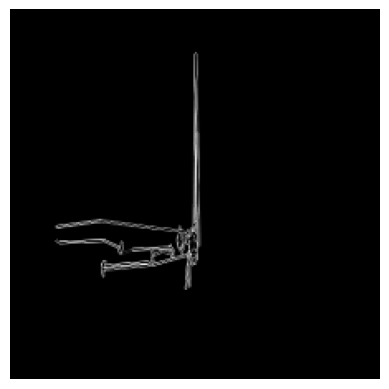

In [29]:
show_image(data[0])

<h2> Data augmentation </h2>

In the augmentation step, we will be rotating every image to obtain a dataset consisting of .. images.

In [84]:
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
#   layers.RandomRotation(0.2),
# ])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   # Random horizontal and vertical flips
    layers.RandomRotation(0.2),                       # Random rotation (20% of image's range)
    layers.RandomZoom(0.1),                           # Random zoom (zoom by 10%)
    # layers.RandomContrast(0.2),                       # Random contrast adjustment
    # layers.RandomBrightness(0.2),                     # Random brightness adjustment
    #layers.RandomHeight(0.1),                         # Random vertical height shift (10%)
    #layers.RandomWidth(0.1),                          # Random horizontal width shift (10%)
])

def augment_multiple_times(data, labels, augmentations=5, batch_size=32):
    """
    Augment data multiple times in smaller batches to prevent GPU memory overflow.

    Args:
        data (tf.Tensor): Input tensor of images.
        labels (tf.Tensor): Corresponding labels.
        augmentations (int): Number of augmentations to apply.
        batch_size (int): Number of images to process per batch.

    Returns:
        augmented_images (tf.Tensor): Tensor of augmented images.
        augmented_labels (tf.Tensor): Tensor of augmented labels.
    """
    augmented_images = []
    augmented_labels = []

    for i in range(0, data.shape[0], batch_size):
        # Get the current batch
        batch_data = data[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Augment the current batch
        for _ in range(augmentations):
            augmented_images.append(data_augmentation(batch_data))
            augmented_labels.append(batch_labels)

    # Concatenate all augmented batches
    augmented_images = tf.concat(augmented_images, axis=0)
    augmented_labels = tf.concat(augmented_labels, axis=0)

    return augmented_images, augmented_labels


In [31]:
dataset = create_dataset(data, labels)

In [38]:
#save_dataset(dataset, "original_dataset")

In [39]:
data, labels = get_data_and_labels(dataset)

In [40]:
data.shape

(544, 224, 224, 1)

In [41]:
with tf.device('/CPU:0'):
    augmented_data, augmented_labels = augment_multiple_times(data, labels, augmentations=10, batch_size=batch_size)

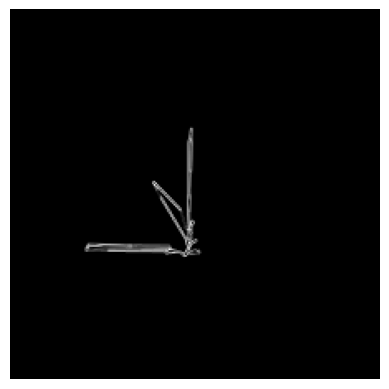

tf.Tensor(b'TC', shape=(), dtype=string)


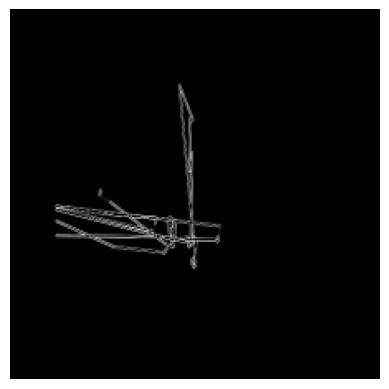

tf.Tensor(b'TS', shape=(), dtype=string)


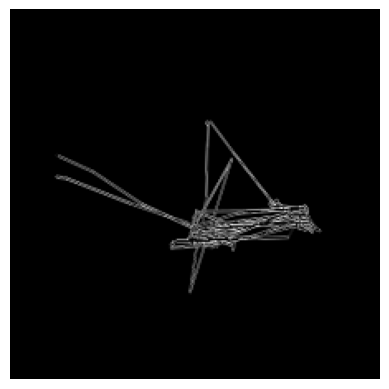

tf.Tensor(b'TC', shape=(), dtype=string)


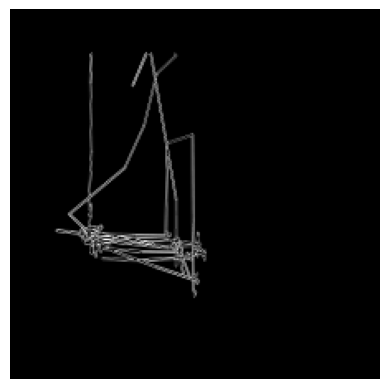

tf.Tensor(b'TS', shape=(), dtype=string)


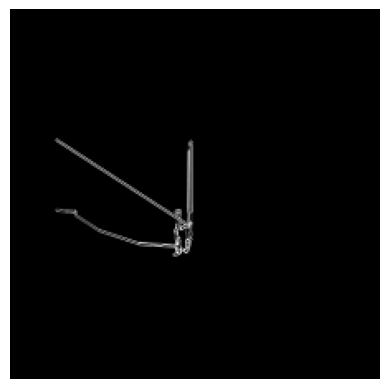

tf.Tensor(b'TC', shape=(), dtype=string)


In [42]:
# Apply data augmentation
for i in range(5):
    show_image(augmented_data[i])
    print(augmented_labels[i])

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_intensity_histogram(image, bins=50):
    """
    Plots the pixel intensity histogram of a grayscale image.

    Args:
        image (np.array): Grayscale image (2D array).
        bins (int): Number of bins for the histogram.

    Returns:
        None
    """
    if image.ndim != 3:
        raise ValueError("The input image must be a grayscale (2D) image.")

    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=bins, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [44]:
combined_data = np.concatenate((data, augmented_data), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

In [45]:
with tf.device('/CPU:0'):
    pre_pca_combined = create_dataset(combined_data, combined_labels)

In [46]:
with tf.device('/CPU:0'):
    train_dataset_pca, test_dataset_pca = tf.keras.utils.split_dataset(
        pre_pca_combined,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

    train_dataset_pca, val_dataset_pca = tf.keras.utils.split_dataset(
        train_dataset_pca,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

<h2>Image segmentation</h2>

Using snake algorithm to detect ROIs 

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import morphological_chan_vese
from skimage.filters import gaussian
from skimage import exposure
from skimage.draw import disk

def process_batch(preprocessed_images, max_iterations=100):
    segmented_images = []

    for idx, img in enumerate(preprocessed_images):
        if len(img.shape) > 2:
            img = img.mean(axis=2)  # Convert to grayscale

        # Enhance contrast
        img = exposure.equalize_hist(img)

        # Apply Gaussian blur
        #img = gaussian(img, sigma=1)

        # Create an initial level set (e.g., a small circle in the center)
        initial_level_set = np.zeros(img.shape, dtype=np.bool_)
        rr, cc = disk((img.shape[0] // 2, img.shape[1] // 2), radius=80)
        initial_level_set[rr, cc] = True

        results=[]
        def store_levelset(levelset):
            # Store the levelset after each iteration (for visualization or inspection purposes)
            results.append(levelset.copy())

        # Perform morphological Chan-Vese segmentation
        morphological_chan_vese(img, num_iter=max_iterations,init_level_set=initial_level_set, lambda1=1, lambda2=1, iter_callback=store_levelset)

        # Store the final levelset
                # Store the final levelset
        final_segmentation = results[-1]

        # Expand dimensions to (H, W, 1) to signify grayscale
        final_segmentation = np.expand_dims(final_segmentation, axis=-1)

        segmented_images.append(final_segmentation)

        # Visualization
        # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        # fig.suptitle(f"Segmentation Process for Image {idx+1}")

        # # Show original image
        # axes[0].imshow(img, cmap='gray')
        # axes[0].set_title("Original Image")
        # axes[0].axis("off")

        # # Show segmentation at different iterations
        # # for i in range(max_iterations):
        # #     axes[i + 1].imshow(results[i], cmap='gray')
        # #     #axes[i + 1].set_title(f"Iteration {i+1}")
        # #     axes[i + 1].axis("off")
        # axes[1].imshow(results[max_iterations], cmap='gray')
        # axes[1].axis("off")
        # plt.show()
        

    return np.array(segmented_images)


In [75]:
with tf.device('/CPU:0'):
    train_data, train_labels = get_data_and_labels(train_dataset_pca)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, feature, morphology, segmentation, exposure, color
from scipy import ndimage as ndi

def watershed_segmentation(image):
    """
    Perform watershed segmentation on an image with fine lines on a black background.

    Args:
        image (np.array): Input image (grayscale or RGB).

    Returns:
        np.array: Segmented image.
    """
    # Convert to grayscale if the image is RGB
    # if len(image.shape) > 2:
    #     image = color.rgb2gray(image)

    # Enhance contrast
    image = exposure.equalize_hist(image)

    # Apply Gaussian blur to reduce noise
    image = filters.gaussian(image, sigma=1)

    # Compute the gradient magnitude using the Sobel operator
    gradient = filters.sobel(image)

    # Create markers for the foreground (lines) and background
    # Threshold the gradient to identify regions of interest
    markers = np.zeros_like(image, dtype=np.int32)
    foreground_threshold = 0.1  # Adjust this threshold as needed
    markers[image > foreground_threshold] = 1  # Foreground (lines)
    markers[image <= foreground_threshold] = 2  # Background

    # Apply the watershed algorithm
    labels = segmentation.watershed(gradient, markers)

    # Remove the background label (2) to isolate the lines
    segmented_image = (labels == 1).astype(np.uint8)

    return segmented_image

def process_batch_with_watershed(preprocessed_images):
    """
    Process a batch of images using watershed segmentation.

    Args:
        preprocessed_images (np.array): Batch of images (batch_size, height, width).

    Returns:
        list: List of segmented images for each image in the batch.
    """
    segmented_images = []

    for idx, img in enumerate(preprocessed_images):
        # Perform watershed segmentation
        segmented_img = watershed_segmentation(img)

        # Store the segmented image
        segmented_images.append(segmented_img)

        # Visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Image {idx+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(segmented_img, cmap='gray')
        plt.title(f"Segmented Image {idx+1}")
        plt.axis("off")

        plt.show()

    return np.array(segmented_images)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


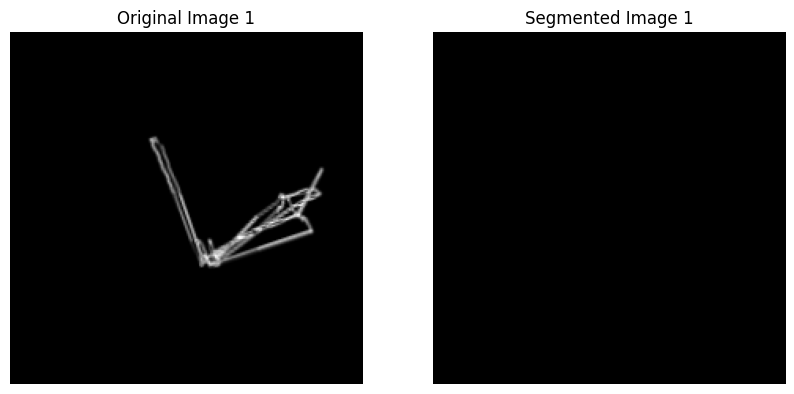

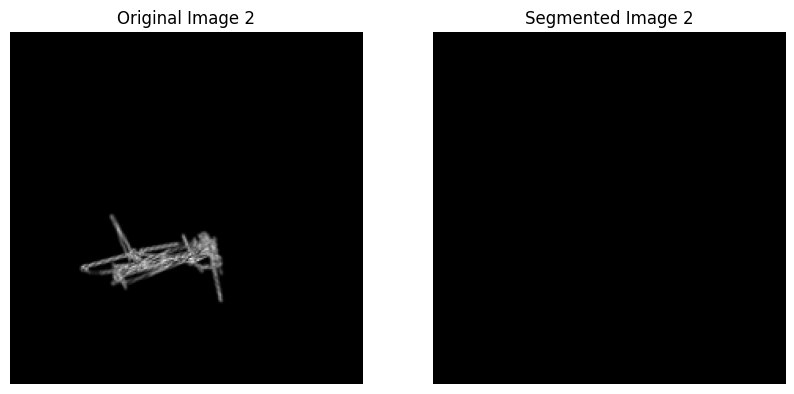

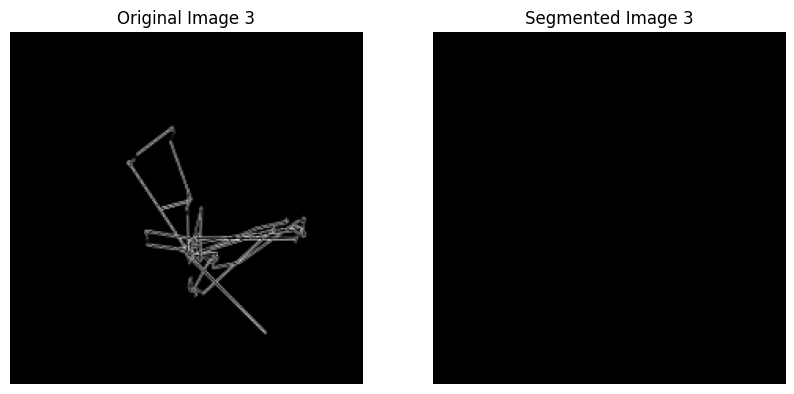

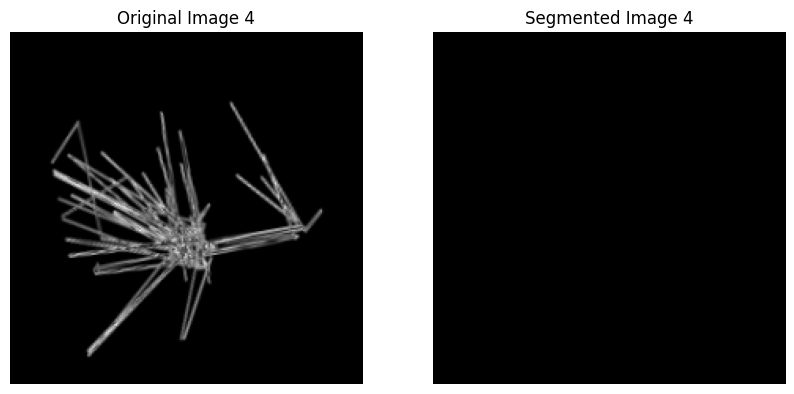

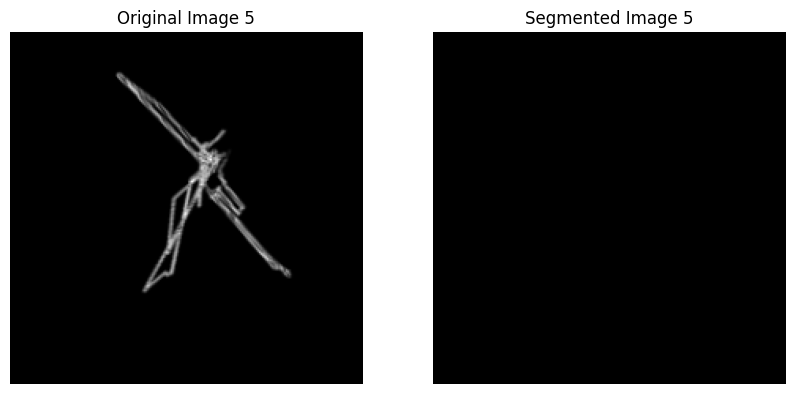

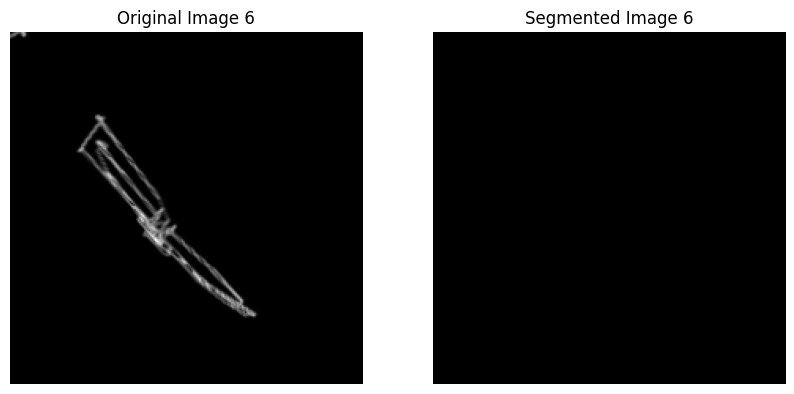

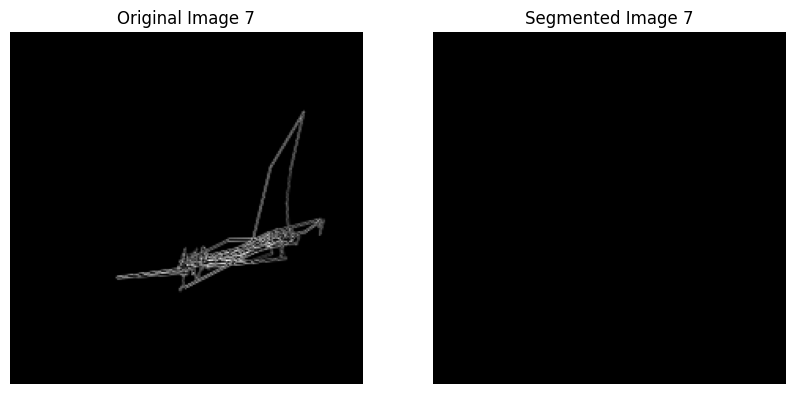

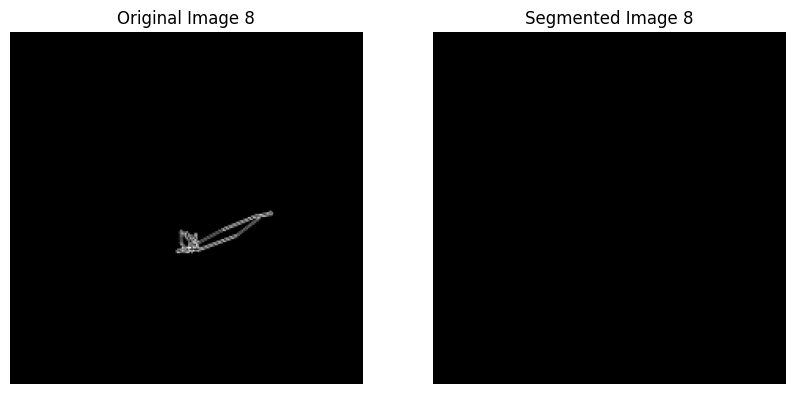

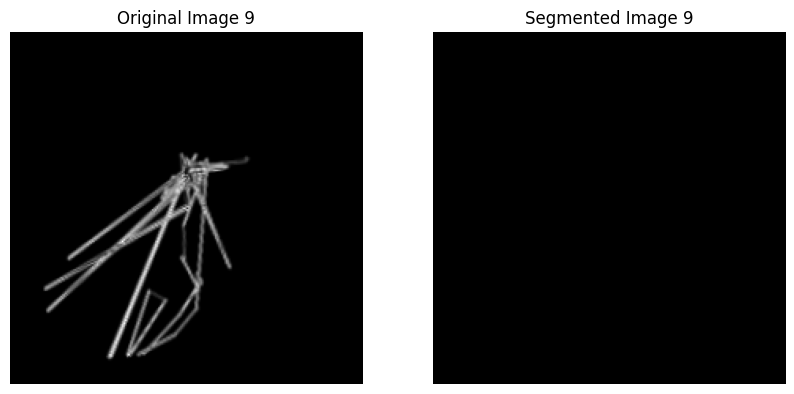

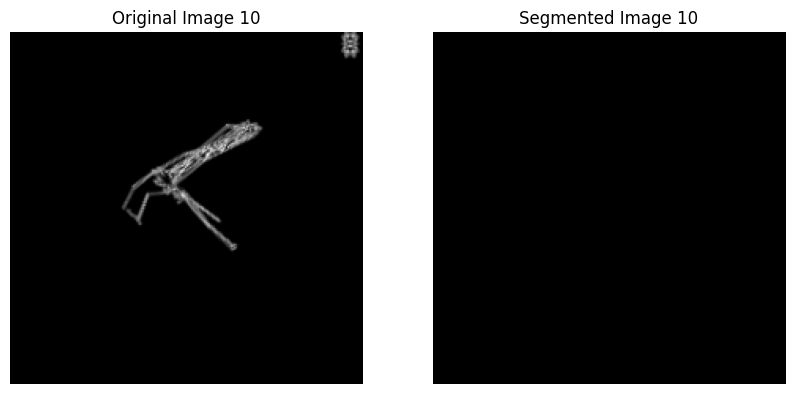

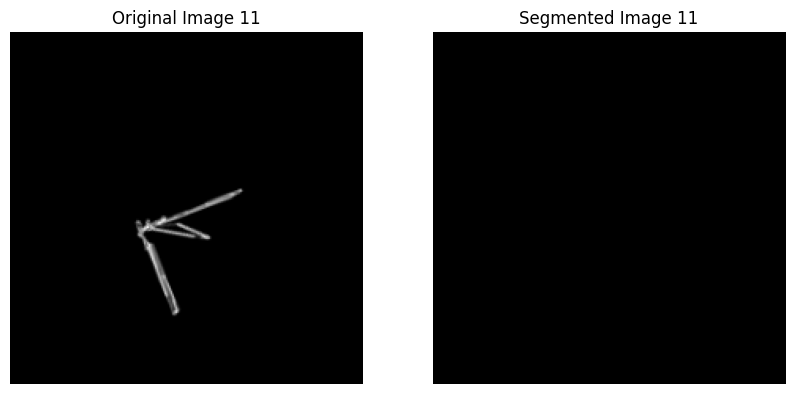

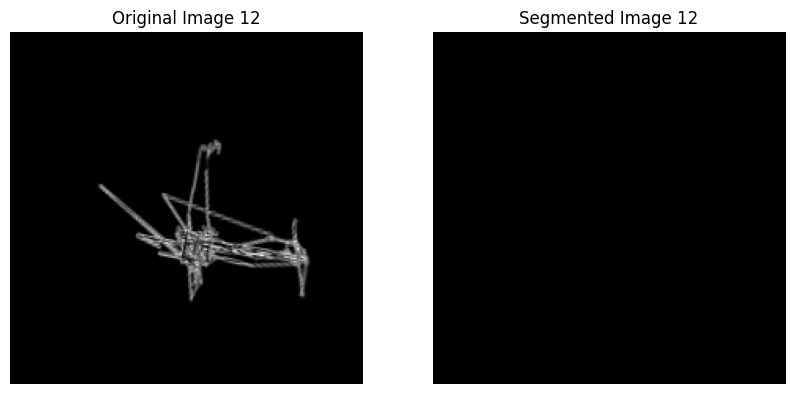

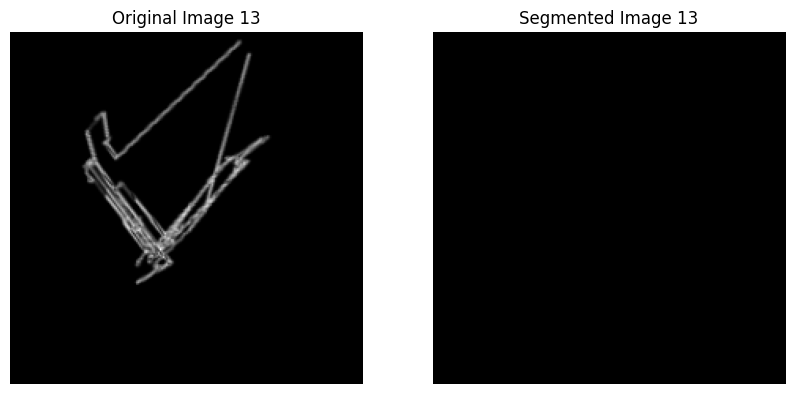

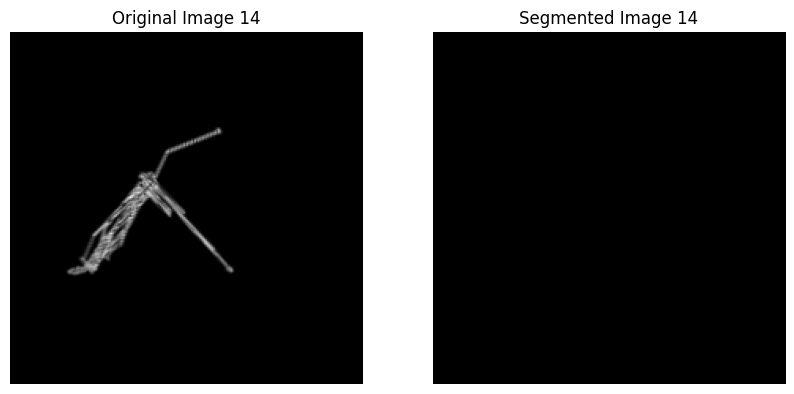

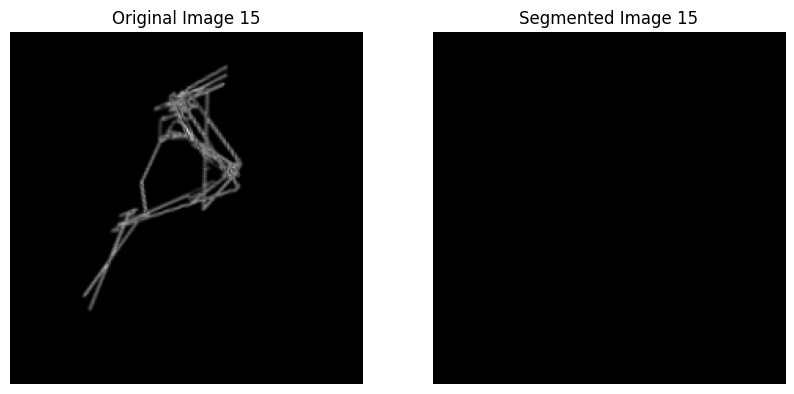

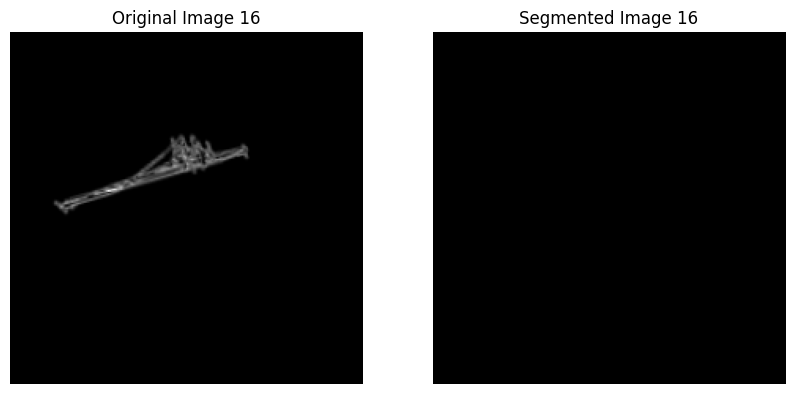

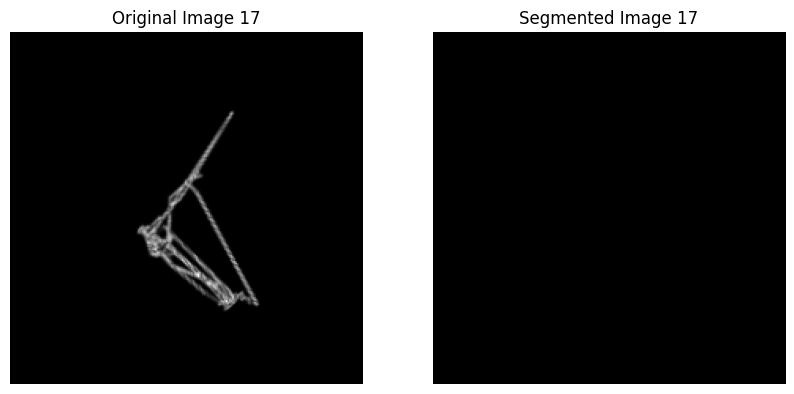

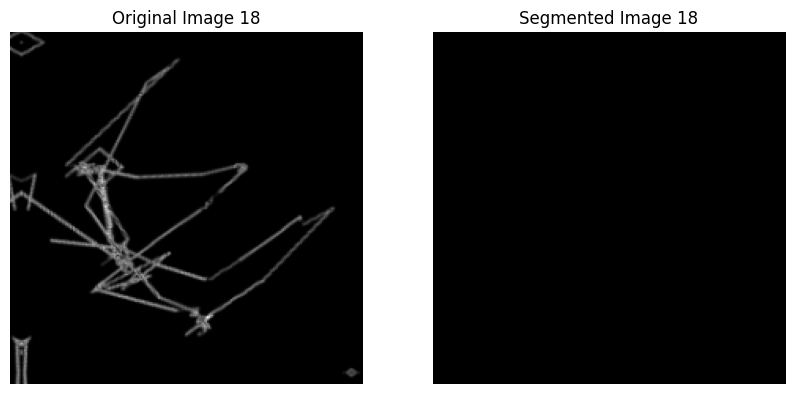

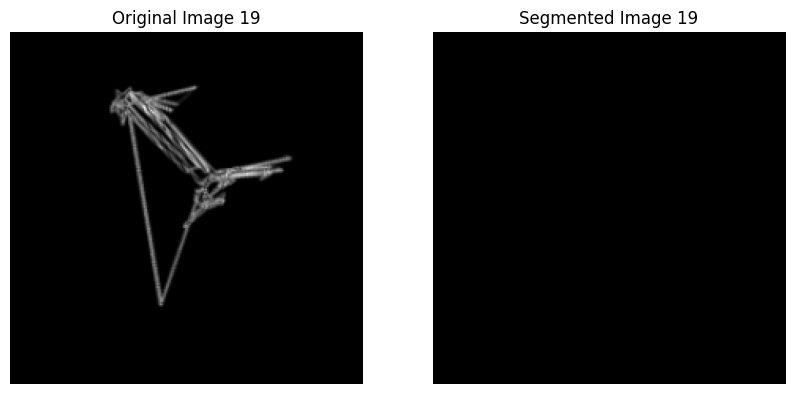

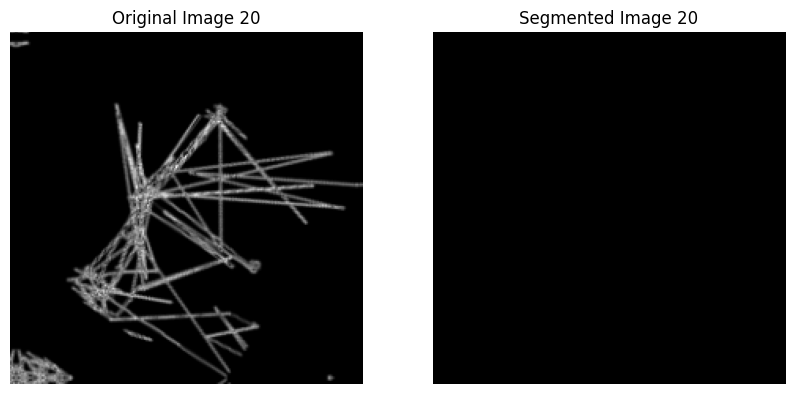

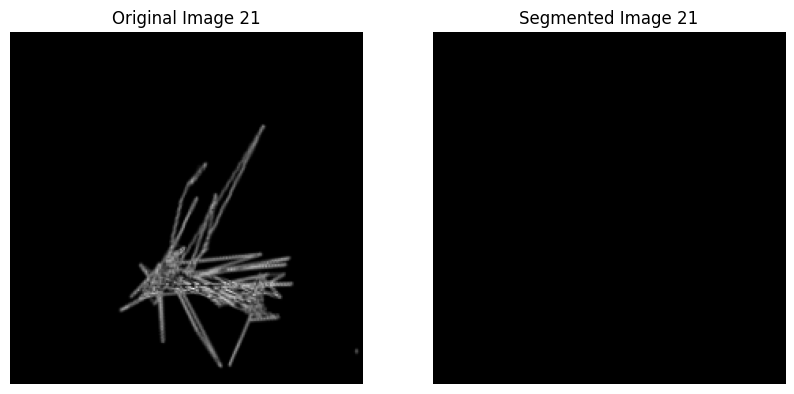

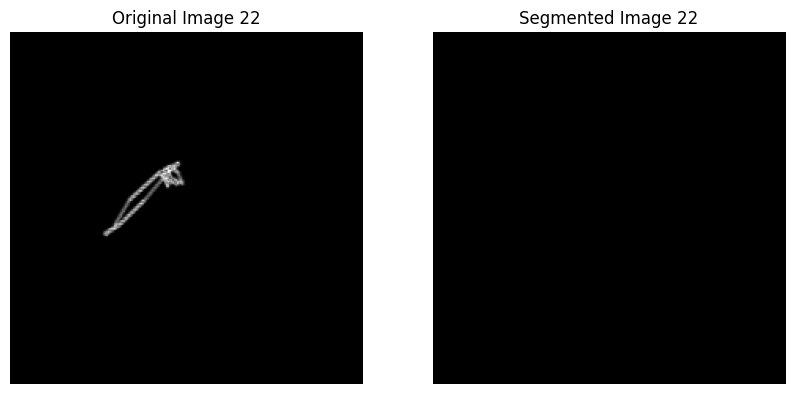

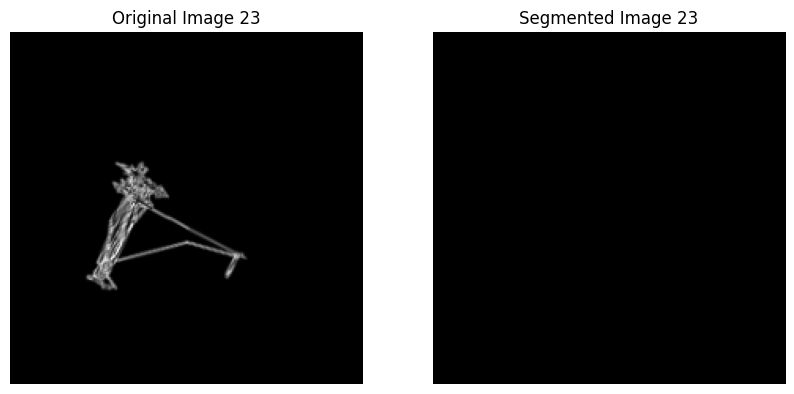

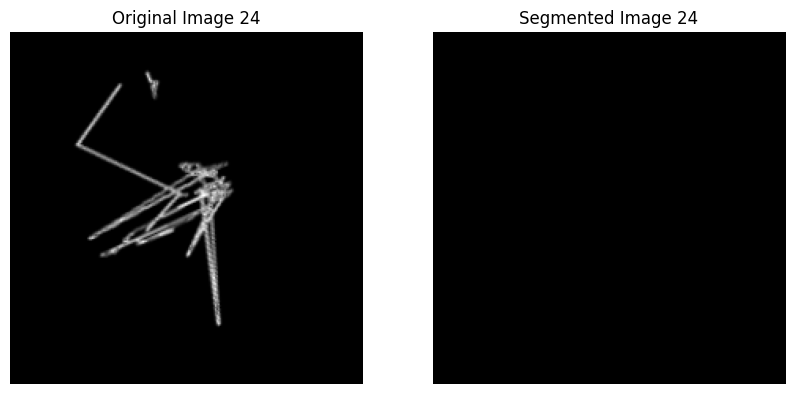

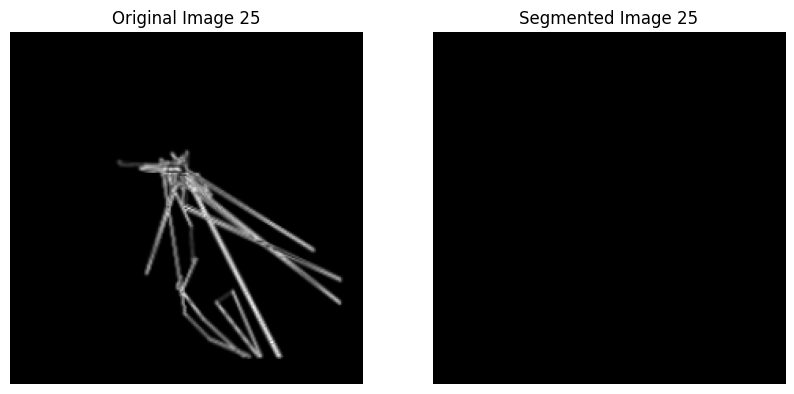

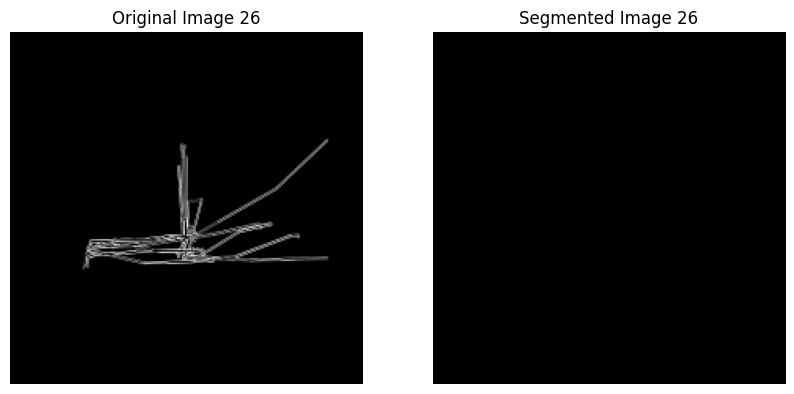

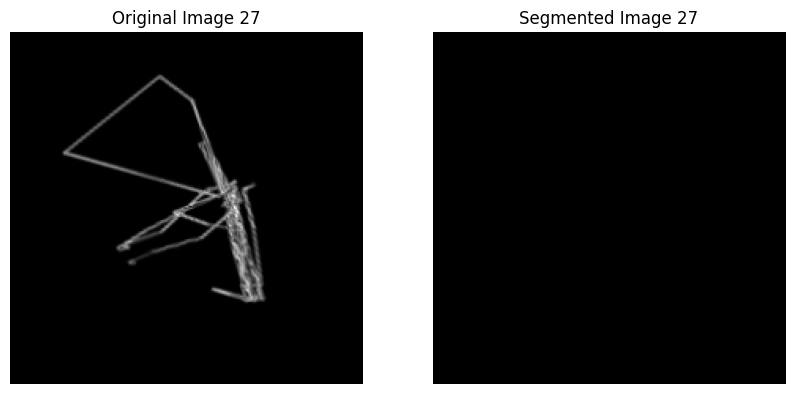

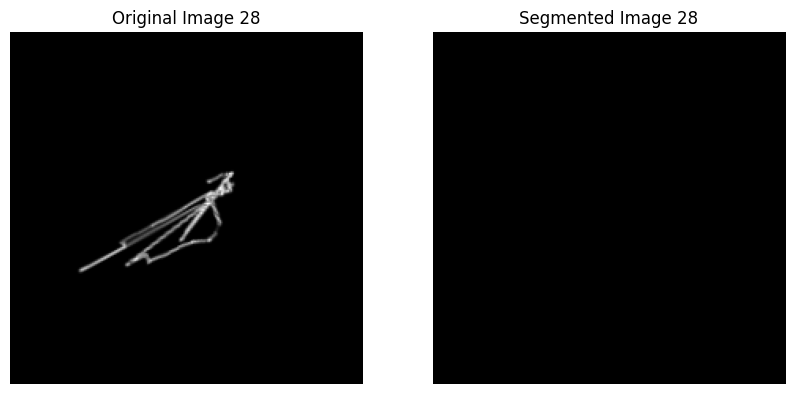

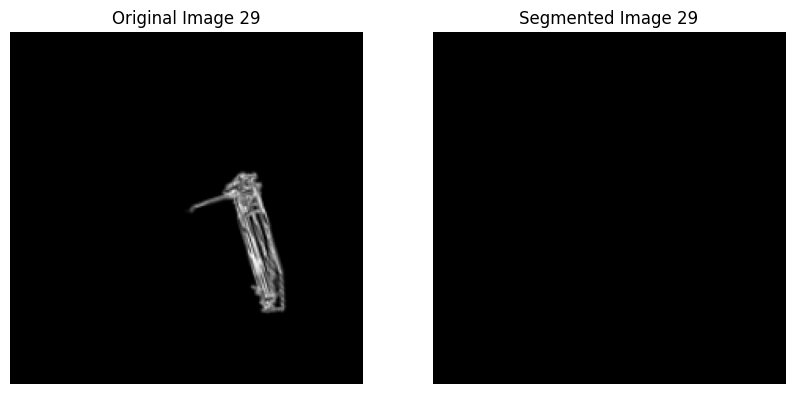

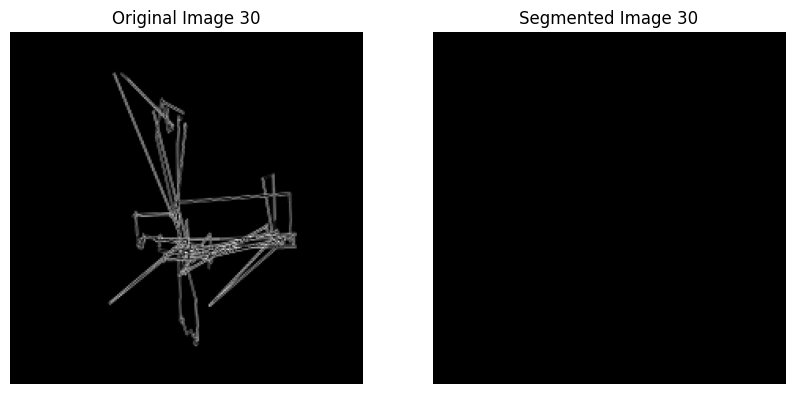

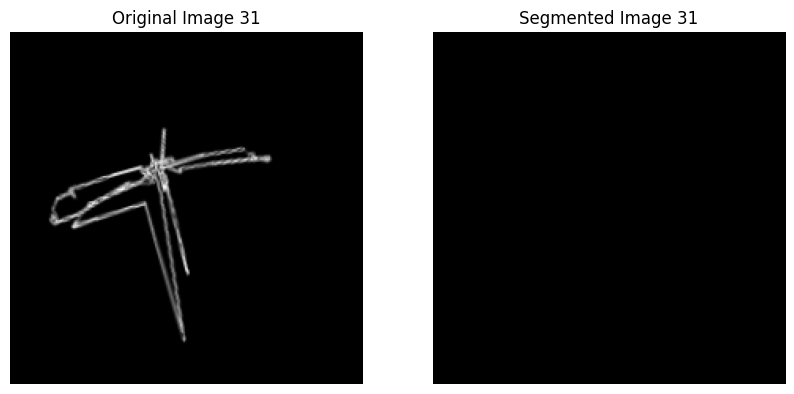

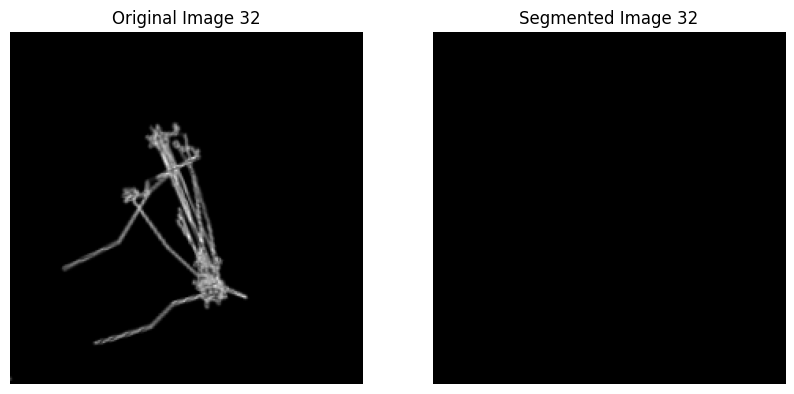

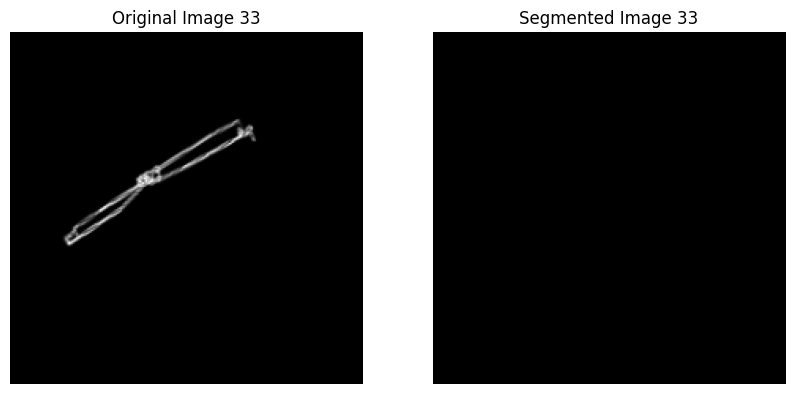

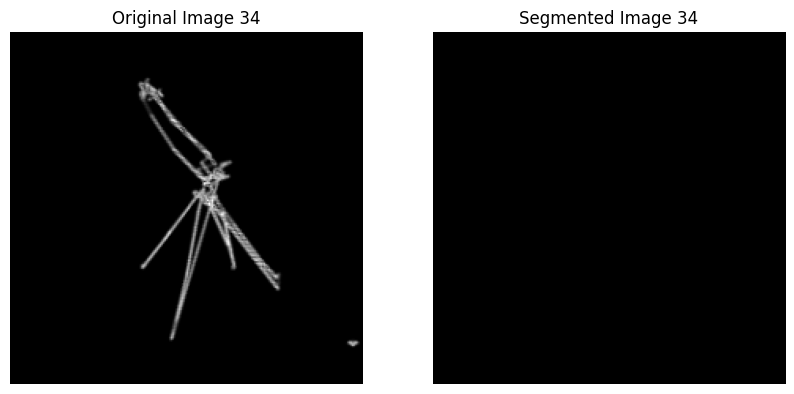

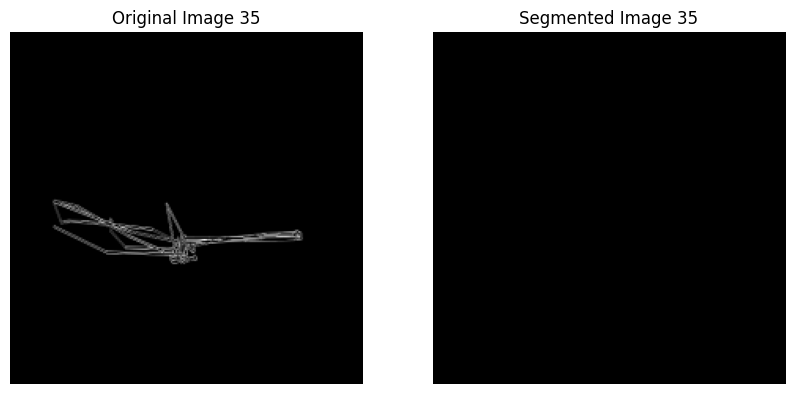

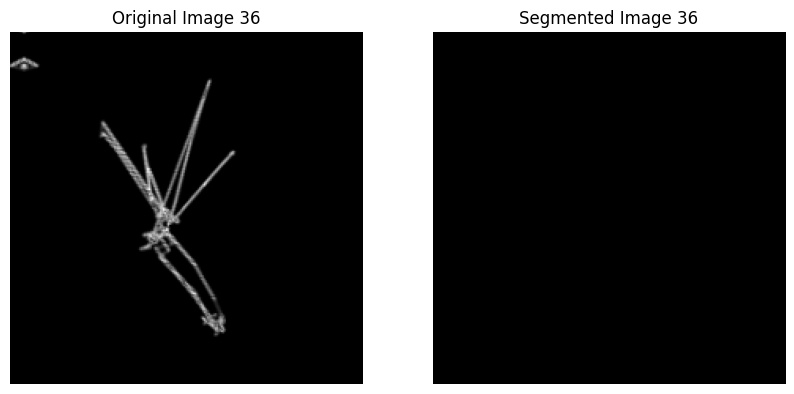

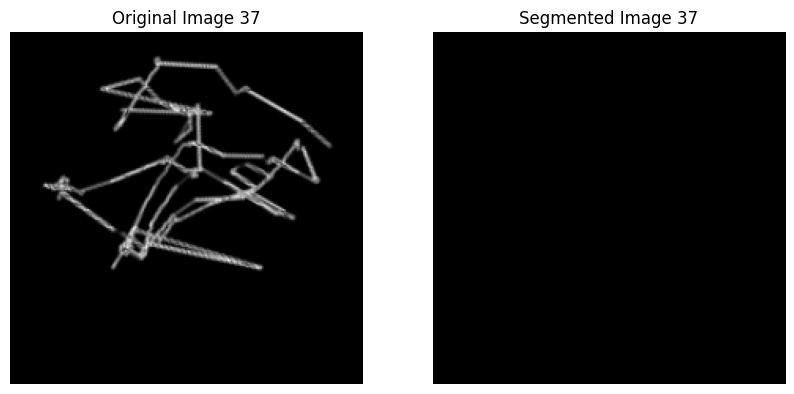

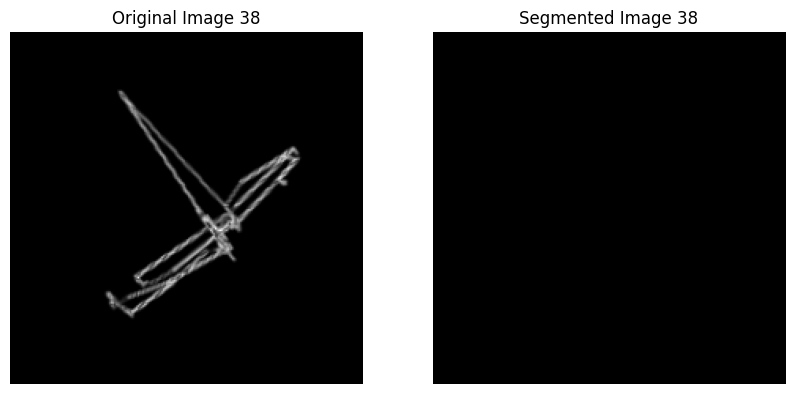

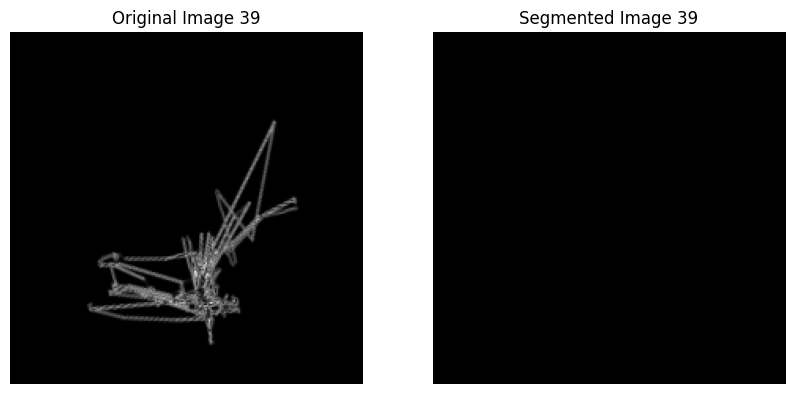

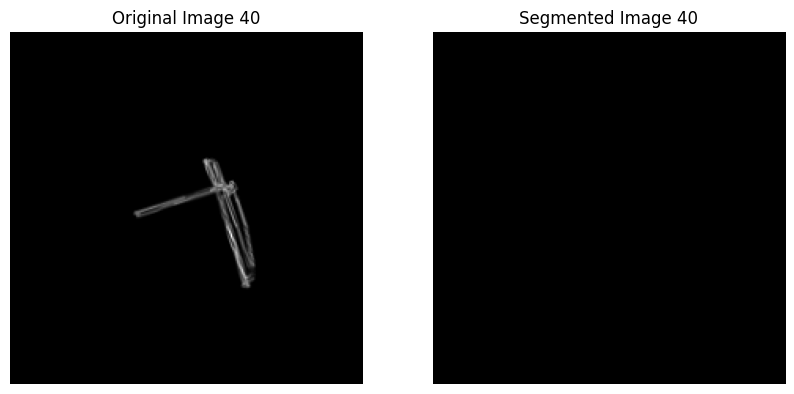

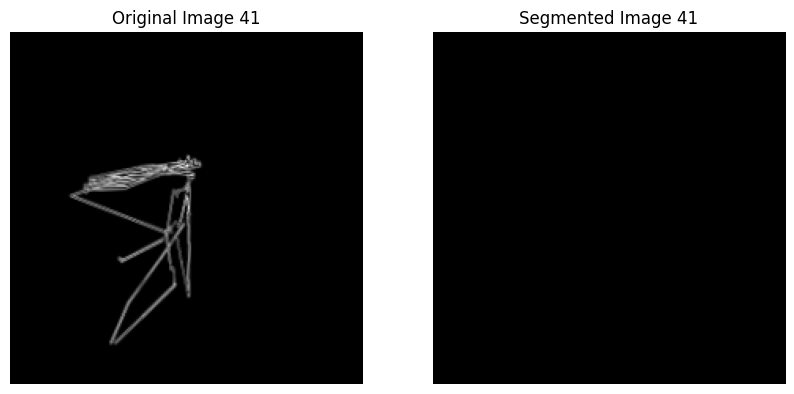

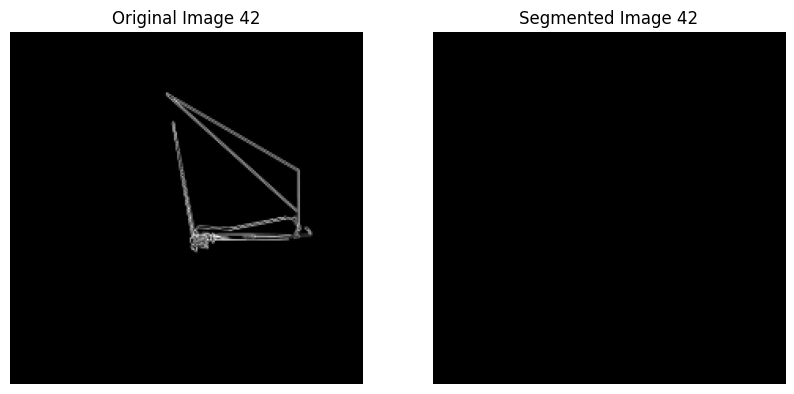

KeyboardInterrupt: 

In [ ]:
#process_batch_with_watershed(train_data)

In [ ]:
segmented_images= process_batch(train_data) #pre pca post segmentation dataset saved

In [ ]:
segmented_images.shape

(3824, 224, 224, 1)

In [76]:
for i in range(10):
    show_image(train_data[i])
    show_image(segmented_images[i])

IndexError: tuple index out of range

In [ ]:
if train_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = segmented_images.reshape(segmented_images.shape[0], -1)

In [81]:
# # Initialize SMOTE to oversample only class 1 to 200 samples
# smote = SMOTE(sampling_strategy=1.0, random_state=42)

# # Apply SMOTE
# train_data, train_labels = smote.fit_resample(X_train, train_labels)

#print("New class distribution:", y_resampled.shape)

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_data, train_labels = adasyn.fit_resample(X_train, train_labels)


c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\sklearn\utils\multiclass.py:348: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\sklearn\utils\multiclass.py:348: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(


ValueError: No samples will be generated with the provided ratio settings.

SAAAAAUU

. Region-Based Segmentation

    Region Growing: Starts with seed points and grows regions by adding neighboring pixels with similar properties.
    Watershed Algorithm: Treats the image as a topographic surface and segments regions based on catchment basins.
    Use Cases: Medical imaging, where homogeneity in regions (like tissues) is important.

In [192]:
def region_based_segmentation(image, seed_point, tolerance=30):
    """
    Perform region-based segmentation using the flood fill algorithm (color-based).
    
    Args:
    - image: Input image (color).
    - seed_point: Starting point for the flood fill (x, y).
    - tolerance: Tolerance value to consider neighboring pixels similar (default is 30).
    
    Returns:
    - segmented_image: The segmented image where regions are filled.
    """
    # Convert the image to RGB if it's in BGR format
    if len(image.shape) == 3:
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        img = image.copy()

    # Create a mask for the flood fill operation
    mask = np.zeros((img.shape[0] + 2, img.shape[1] + 2), np.uint8)

    # Extract color at the seed point
    color_at_seed = img[seed_point[1], seed_point[0]]

    # Convert RGB to BGR (OpenCV uses BGR by default)
    color_at_seed_bgr = (color_at_seed[2], color_at_seed[1], color_at_seed[0])

    # Perform flood fill at the seed point
    flooded_image = img.copy()
    cv2.floodFill(flooded_image, mask, seed_point, color_at_seed_bgr, loDiff=tolerance, upDiff=tolerance)

    # Convert the flooded image to a binary image
    # All pixels that belong to the region of the flood fill will be white
    # Otherwise, they will be black (0)
    segmented_image = np.all(flooded_image == color_at_seed_bgr, axis=-1)
    segmented_image = segmented_image.astype(np.uint8) * 255

    return segmented_image


In [ ]:
#segmented_image = region_based_segmentation(train_data[0], (0,0))

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'floodFill'
> Overload resolution failed:
>  - Scalar value for argument 'newVal' is not numeric
>  - Scalar value for argument 'newVal' is not numeric


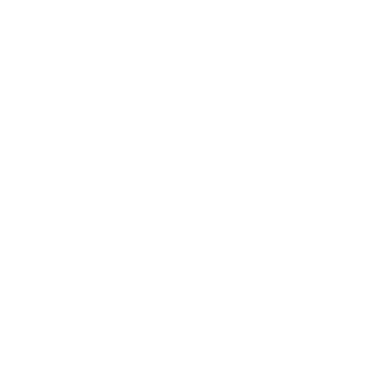

In [ ]:
#show_image(segmented_image)

<h1> START OF PCA PIPELINE </H1>
Feature extraction
PCA

-different from the paper: i am applying pca only to trained data

In [83]:
from sklearn.preprocessing import StandardScaler

def apply_pca(data, labels, n_components=50):
    """
    Apply PCA to reduce the dimensionality of flattened image data.
    Args:
        data (np.array): Flattened image data of shape (n_samples, height * width).
        labels (np.array): Corresponding labels of shape (n_samples,).
        n_components (int): Number of principal components to keep.
    Returns:
        np.array, np.array, PCA: Transformed data, labels, and PCA model.
    """
    data = data.reshape(data.shape[0], -1)
    # Ensure the data is 2D (flattened images)
    # if data.ndim == 3 and data.shape[-1] == 1:  # Handle (n_samples, height, 1)
    #     data = np.squeeze(data, axis=-1)

    if data.ndim != 2:
        raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {data.shape}.")

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Initialize PCA and fit it on the flattened data
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance by Principal Components")
    plt.grid()
    plt.show()

    return data_pca, labels, pca, scaler


In [84]:
train_data = train_data.reshape(train_data.shape[0], -1)
# Ensure the data is 2D (flattened images)
# if data.ndim == 3 and data.shape[-1] == 1:  # Handle (n_samples, height, 1)
#     data = np.squeeze(data, axis=-1)

if train_data.ndim != 2:
    raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {train_data.shape}.")

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Initialize PCA and fit it on the flattened data
pca = PCA(n_components=500)
train_data_pca = pca.fit_transform(train_data_scaled)

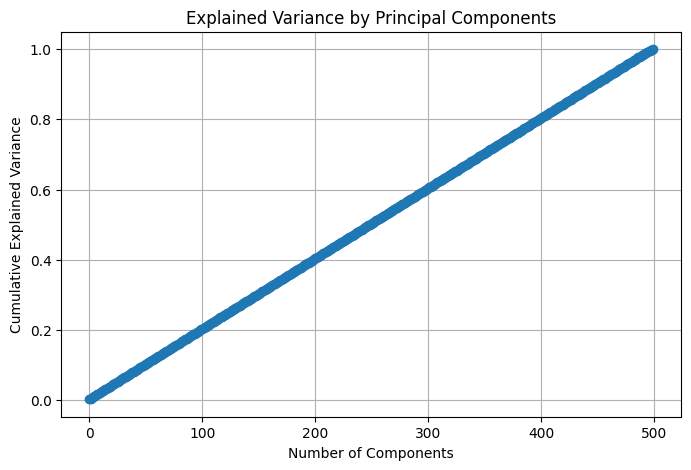

In [154]:
n_components=500
with tf.device('/CPU:0'):
    train_data_pca, train_labels_pca, pca_model, scaler = apply_pca(train_data, train_labels, n_components=n_components)

In [ ]:
with tf.device('/CPU:0'):
    val_data, val_labels = get_data_and_labels(val_dataset_pca)




In [118]:
val_data_segmented = process_batch(val_data)

In [119]:
if val_data_segmented.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    val_data_segmented = val_data_segmented.reshape(val_data_segmented.shape[0], -1)

In [120]:
val_data_scaled = scaler.transform(val_data_segmented)

In [121]:
val_data_scaled.std(), train_data_scaled.std()

(0.9762629208497271, 0.9117094527729147)

In [122]:
val_data_pca = pca.transform(val_data_scaled)

In [123]:
train_applied_pca = create_dataset(train_data_pca, train_labels)

val_applied_pca = create_dataset(val_data_pca, val_labels)

In [ ]:
#save_dataset(combined_dataset_pca, "combined_dataset_pca")

In [ ]:
#combined_dataset_pca = load_dataset("combined_dataset_pca")

In [124]:
from tensorflow.keras.layers import BatchNormalization
n_components=500

def create_model_pca(input_shape, n_classes):
    model = Sequential([
       Dense(64, activation='relu', input_shape=(n_components,), kernel_regularizer=l2(0.02)),
       BatchNormalization(),
        Dropout(0.3),  # Helps prevent overfitting
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
       Dropout(0.5),
        Dense(2, activation='softmax')  # Assuming 2 classes
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  #loss='binary_focal_crossentropy',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize model
model_pca = create_model_pca(input_shape=(n_components,), n_classes=2)

# Display model summary
model_pca.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [125]:
train_dataset = train_applied_pca.map(one_hot_encode)

val_dataset = val_applied_pca.map(one_hot_encode)

TypeError: in user code:

    File "C:\Users\Alex\AppData\Local\Temp\ipykernel_3644\2226799771.py", line 14, in one_hot_encode  *
        label = class_mapping.lookup(label)

    TypeError: Dtype of argument `keys` must be <dtype: 'string'>, received: <dtype: 'float32'>


In [ ]:
val_data, val_labels = get_data_and_labels(val_dataset)

train_data, train_labels = get_data_and_labels(train_dataset)

<h2> Fine tuning hyperparameters </h2>

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def model_builder(hp):
    model = Sequential()

    # Dense Layer 1 (Optional)
    if hp.Boolean('dense1_add'):
        model.add(Dense(
            units=hp.Choice('dense1_units', values=[8, 16, 32, 64, 128, 256]),
            activation='relu'
        ))
        model.add(BatchNormalization())  # Add Batch Normalization
        if hp.Boolean('dense1_dropout'):
            model.add(Dropout(rate=hp.Float('dense1_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense Layer 2 (Optional)
    if hp.Boolean('dense2_add'):
        model.add(Dense(
            units=hp.Choice('dense2_units', values=[8, 16, 32, 64, 128, 256]),
            activation='relu'
        ))
        model.add(BatchNormalization())  # Add Batch Normalization
        if hp.Boolean('dense2_dropout'):
            model.add(Dropout(rate=hp.Float('dense2_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense Layer 3 (Optional)
    if hp.Boolean('dense3_add'):
        model.add(Dense(
            units=hp.Choice('dense3_units', values=[8, 16, 32, 64, 128, 256]),
            activation='relu'
        ))
        model.add(BatchNormalization())  # Add Batch Normalization
        if hp.Boolean('dense3_dropout'):
            model.add(Dropout(rate=hp.Float('dense3_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer (Softmax for binary classification with one-hot encoded labels)
    # Hardcoding the output units to 2 (binary classification)
    model.add(Dense(
        2,  # 2 output units for binary classification (one-hot encoded labels)
        activation='softmax'  # Softmax for binary classification with one-hot encoded labels
    ))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoding
        metrics=['accuracy']
    )
    
    return model

# Create a Hyperband tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir_pca_3',
    project_name='pca_tuning_3'
)

# Search for the best hyperparameters
tuner.search(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30
)


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

# Print all hyperparameters and their values
for hp_name in best_hps.values:
    print(f"{hp_name}: {best_hps.get(hp_name)}")


In [ ]:
#model_pca = tuner.hypermodel.build(best_hps)

<h2> Model training </h2>

In [93]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define step decay function
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epoch_drop = 10.0
    lr = initial_lr * np.power(drop, np.floor((1+epoch)/epoch_drop))
    return lr

# Instantiate the learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay)

In [94]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [126]:
reset_weights(model_pca)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [95]:
from sklearn.utils.class_weight import compute_class_weight

train_la = np.argmax(train_labels, axis=1)
train_1d=train_la.ravel()

class_weights = compute_class_weight('balanced',  classes=np.unique(train_1d), y=train_1d)

AxisError: axis 1 is out of bounds for array of dimension 1

In [127]:
history_pca = model_pca.fit(train_dataset, batch_size=batch_size, epochs=50,callbacks=[early_stopping, reduce_lr],validation_data=val_dataset,
                            #class_weight={0: 0.8, 1: 1.2}, 
                            )

Epoch 1/50
298/298 [==============================] - 3s 6ms/step - loss: 3.0764 - accuracy: 0.5382 - val_loss: 27.0621 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 2/50
298/298 [==============================] - 2s 6ms/step - loss: 1.9795 - accuracy: 0.5713 - val_loss: 21.4130 - val_accuracy: 0.3865 - lr: 0.0010
Epoch 3/50
298/298 [==============================] - 2s 6ms/step - loss: 1.3466 - accuracy: 0.6147 - val_loss: 23.2843 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 4/50
298/298 [==============================] - 2s 6ms/step - loss: 1.0268 - accuracy: 0.6344 - val_loss: 21.9220 - val_accuracy: 0.3938 - lr: 0.0010
Epoch 5/50
298/298 [==============================] - 2s 5ms/step - loss: 0.8822 - accuracy: 0.6546 - val_loss: 21.7992 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 6/50
298/298 [==============================] - 2s 6ms/step - loss: 0.8109 - accuracy: 0.6741 - val_loss: 19.9129 - val_accuracy: 0.3896 - lr: 0.0010
Epoch 7/50
298/298 [==============================] - 2s 5ms/ste

In [86]:
import pandas as pd

#train_labels = np.argmax(train_labels, axis=1)
# Assuming 'y_train' is your target variable (labels)
class_distribution = pd.Series(train_labels).value_counts()
print(class_distribution)

ValueError: Data must be 1-dimensional, got ndarray of shape (4768, 2) instead

In [ ]:
# model_pca.save_weights('./checkpoints/pca_100_accuracy')
# model_pca.save('pca_100.h5', save_format='h5')

In [85]:
model_forest= RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500 )

In [87]:
from sklearn.svm import SVC

model_svm= SVC(random_state=42, C=5, gamma= 0.001, kernel= 'rbf', degree=1)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Define hyperparameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Set up GridSearchCV
# grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
# grid_search_rf.fit(X_train, train_labels)
# print(f"Best parameters for RF: {grid_search_rf.best_params_}")

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Define hyperparameter grid for SVM
# param_grid_svc = {
#     'C': [0.1, 1, 5, 10], #5
#     #'kernel': ['linear', 'rbf', 'poly'], #rbf
#     #'degree': [1,2,3,4,5], #1
#     'gamma': [0.001, 0.1, 1], #0.01
# }

# # Set up GridSearchCV
# grid_search_svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, cv=2, n_jobs=-1)
# grid_search_svc.fit(X_train, train_labels)
# print(f"Best parameters for SVC: {grid_search_svc.best_params_}")

In [88]:
test_dataset_pca = test_dataset_pca.map(one_hot_encode)

In [89]:
X_test, y_test = get_data_and_labels(test_dataset_pca)

In [98]:
train_data.shape, train_labels.shape, train_data_pca.shape, segmented_images.shape

((4768, 500), (4768, 2), (4778, 500), (3824, 224, 224, 1))

In [93]:
if train_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = train_data_pca.reshape(train_data_pca.shape[0], -1)

if test_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_test = test_data.reshape(test_data.shape[0], -1)

In [94]:
history_forest = model_forest.fit(X_train, train_labels)

y_pred = model_forest.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [4778, 4768]

In [363]:
y_test = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

In [367]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred = np.argmax(model_forest.predict(X_test), axis=1)  # If it's one-hot encoded

In [267]:
train_labelss = np.argmax(train_labels, axis=1)

In [371]:
model_svm.fit(X_train, train_labelss)

y_pred_svm = model_svm.predict(X_test)

In [372]:
y_test = np.argmax(y_test, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy SVM: {accuracy}')

Accuracy SVM: 0.6066666666666667


In [370]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6066666666666667


In [373]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report


In [276]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure labels are a 1D array
train_labels_1d = train_labels.ravel()  # Flatten to (N,)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_1d), y=train_labels_1d)
# class_weights = np.array([0.5, 1.5])
# Convert to dictionary for classifiers
class_weight_dict = dict(zip(np.unique(train_labels_1d), class_weights))

print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {0.0: 1.0, 1.0: 1.0}


In [ ]:
e= ExtraTreesClassifier(random_state=42,criterion="log_loss" , max_depth=10,
                        max_features='log2',# class_weight=class_weight_dict,
                        n_estimators=2000, min_samples_leaf=10, n_jobs=-1, warm_start=True).fit(X_train, train_labels)

In [374]:
estimator = []
# estimator.append(('DecisionTreeClassifier', DecisionTreeClassifier(criterion='log_loss', max_features='log2',
#                                                                    class_weight=class_weight_dict,random_state=42)))
#estimator.append(('Neural Network', MLPClassifier(max_iter = 10000) ))
#estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
#estimator.append(('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance') ))
# estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42,criterion="log_loss" , max_depth=10,
#                                                                max_features='log2',# class_weight=class_weight_dict,
#                                                                 n_estimators=2000, min_samples_leaf=10) ))
# estimator.append(('RandomForest', RandomForestClassifier(random_state=42, class_weight=class_weight_dict, n_estimators=500#,min_samples_leaf= 2, min_samples_split= 50
#                                                          ) ))
# estimator.append(('SVC', SVC(random_state=42, probability=True, class_weight=class_weight_dict)))
# estimator.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=42, n_estimators=149, algorithm='SAMME', learning_rate=0.5) ))
estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier(loss='log_loss',
                                                                           min_samples_leaf=10, n_estimators=36,
                                                                            learning_rate=0.01, criterion='squared_error') ))
# estimator.append(('BaggingClassifier', BaggingClassifier(estimator=e, n_estimators=10, random_state=42)))

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Define base classifiers with class weights
rf = RandomForestClassifier(class_weight=class_weight_dict)
svc = SVC(probability=True, class_weight=class_weight_dict)  # Enable probability=True if using soft voting

gb = GradientBoostingClassifier() 

# Create the Voting Classifier
VC_hard = VotingClassifier(estimators=estimator, voting='hard')


# Fit the model
#VC_hard.fit(X_train, train_labels_1d)  # Use 1D labels directly


In [296]:
from sklearn.metrics import mean_squared_error, log_loss

ada= GradientBoostingClassifier(loss='log_loss',
                                                                           min_samples_leaf=5, n_estimators=100,
                                                                            learning_rate=0.01, criterion='squared_error').fit(X_train, train_labelss)

errors = [ log_loss(y_test, preds) for preds in ada.staged_predict(X_test)]

optimal_num_estimators = np.argmin(errors) + 1

In [297]:
optimal_num_estimators

36

In [375]:
from sklearn.metrics import accuracy_score

for name, model in VC_hard.estimators:
    model.fit(X_train, train_labelss)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

GradientBoostingClassifier Accuracy: 0.6066666666666667


In [ ]:
#VC_hard = VotingClassifier(estimators = estimator, voting ='hard')

VC_hard.fit(X_train, train_labels)
y_pred = VC_hard.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [302]:
cm = confusion_matrix(y_test, y_pred)

VC_hard_Recall = recall_score(y_test, y_pred)
VC_hard_Precision = precision_score(y_test, y_pred)
VC_hard_f1 = f1_score(y_test, y_pred)
VC_hard_accuracy = accuracy_score(y_test, y_pred)

VC_hard_Recall, VC_hard_Precision, VC_hard_f1, VC_hard_accuracy, cm

(0.3199152542372881,
 0.7864583333333334,
 0.45481927710843373,
 0.6983333333333334,
 array([[687,  41],
        [321, 151]], dtype=int64))

In [ ]:
train_labels=train_labels.reshape(-1, 1)

# If X_train is image data (e.g., shape (num_samples, height, width, channels)), flatten it
if X_train.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = X_train.reshape(X_train.shape[0], -1)

# Define voting classifier with RandomForest and SVM
voting_clf = VotingClassifier(
    estimators=[
        #('rf', RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500 )),
        ('rf', RandomForestClassifier(random_state=42)),
        #('svc', SVC(random_state=42, C=5, gamma= 0.001, kernel= 'rbf', degree=1, probability=True)),
        ('svc', SVC(random_state=42, probability=True)),
    ],
    voting='soft'
    #voting='hard'
)

# Train the voting classifier
voting_clf.fit(X_train, train_labels)

In [ ]:
y_test_labels = np.argmax(test_labels, axis=1) if test_labels.ndim > 1 else test_labels

voting_clf.score(test_data_pca, y_test)

In [ ]:
y_pred_soft = voting_clf.predict(X_test)

In [ ]:
cm = confusion_matrix(labelss, y_pred_soft)

# VC_hard_Recall = recall_score(labelss, y_pred)
# VC_hard_Precision = precision_score(labelss, y_pred)
# VC_hard_f1 = f1_score(labelss, y_pred)
# VC_hard_accuracy = accuracy_score(labelss, y_pred)

print(cm)

In [ ]:
import pandas as pd

# Assuming 'y_train' is your target variable (labels)
class_distribution = pd.Series(train_labels).value_counts()
print(class_distribution)


In [ ]:
ada = AdaBoostClassifier()

ada.fit(X_train, train_labels)

ada.score(X_test, labelss)

In [ ]:
dataset_encoded = dataset.map(one_hot_encode)

data, labels = get_data_and_labels(dataset_encoded)

In [ ]:
train_datasett, test_datasett = tf.keras.utils.split_dataset(
    dataset_encoded,
    left_size=0.8,
    shuffle=True,
    seed=42
)

In [ ]:
ddata, llabels = get_data_and_labels(train_datasett)

dddata, lllabels = get_data_and_labels(test_datasett)

In [ ]:
llabels = np.argmax(llabels, axis=1)
lllabels = np.argmax(lllabels, axis=1)

In [ ]:
svc = SVC(gamma ='auto', probability = True)

if ddata.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    Xx_train = ddata.reshape(ddata.shape[0], -1)

if dddata.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    Xx_test = dddata.reshape(dddata.shape[0], -1)

svc.fit(Xx_train, llabels)

#svc.score(X_test, labelss)

svc.score(Xx_test, lllabels)


In [ ]:
y_pred = svc.predict(Xx_test)

In [ ]:
print(classification_report(lllabels, y_pred))

In [ ]:
knn = KNeighborsClassifier()

knn.fit(Xx_train, llabels)

knn.score(Xx_test, lllabels)

In [ ]:
y_pred = knn.predict(Xx_test)

print(classification_report(lllabels, y_pred))

In [ ]:
rf= RandomForestClassifier()

rf.fit(X_train, train_labels)

rf.score(X_test, labelss)

In [ ]:
extra= ExtraTreesClassifier()

extra.fit(X_train, train_labels)

extra.score(X_test, labelss)

In [ ]:
lr = LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)

lr.fit(X_train, train_labels)

lr.score(X_test, labelss)

In [ ]:
nn = MLPClassifier(max_iter = 10000)

nn.fit(X_train, train_labels)

nn.score(X_test, labelss)

In [ ]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, train_labels)

In [ ]:
gb.score(X_test, labelss)


<h2> Accuracy graph </h2>

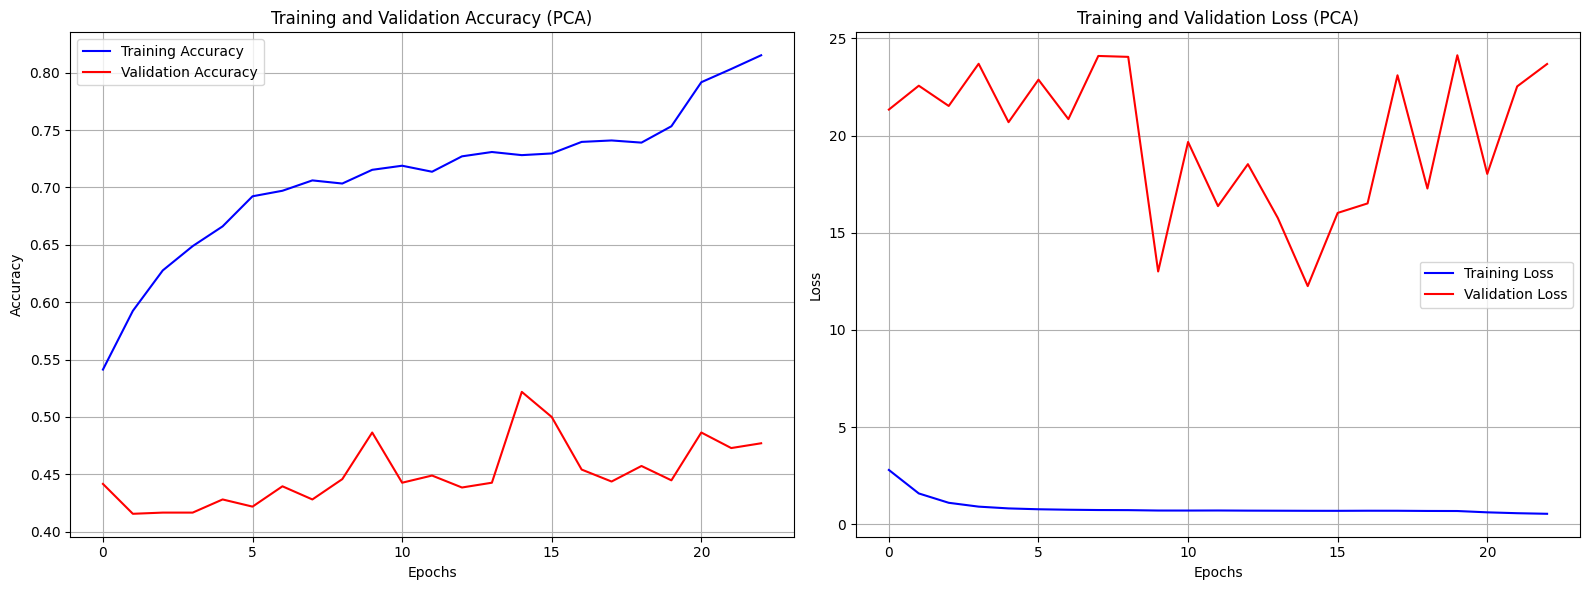

In [78]:
plot_training_history(history_pca, "PCA")

In [179]:
test_data, test_labels = get_data_and_labels(test_dataset_pca)

In [164]:
#test_segmented_images= process_batch(test_data)
test_data_scaled = scaler.transform(test_data)

ValueError: X has 50176 features, but StandardScaler is expecting 500 features as input.

In [165]:
# test_data_pca, test_labels_pca, pca_model = apply_pca(test_segmented_images, test_labels, n_components=n_components)
test_data = test_data.reshape(test_data.shape[0], -1)
test_data_pca = pca_model.transform(test_data_scaled)

NameError: name 'test_data_scaled' is not defined

In [81]:
test_pca = create_dataset(test_data_pca, test_labels)

In [82]:
test_dataset_pca_encoded = test_pca.map(one_hot_encode)

<h2> Overall accuracy score </h2>

In [83]:
# Generate predictions from the model
predictions = np.argmax(model_pca.predict(test_dataset_pca_encoded), axis=-1)

# Extract true labels from the test dataset
true_labels = []
for _, labels in test_dataset_pca_encoded:
    true_labels.extend(np.argmax(labels, axis=-1))  # Convert one-hot to class indices
    
true_labels = np.array(true_labels)  # Convert list to numpy array

# Calculate overall accuracy
overall_accuracy = np.mean(predictions == true_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


75/75 [==============================] - 0s 3ms/step
Overall Accuracy: 0.4283


In [84]:
# Compute precision and recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 score: {f1:.4f}')

Precision: 0.3959
Recall: 0.8684
F1 score: 0.5439


<h2>Cross-validation with k-folds</h2>

In [ ]:
data_unbatched = [x.numpy().flatten() for x, y in train_dataset.unbatch()]
labels_unbatched = [y.numpy() for x, y in train_dataset.unbatch()]

# Convert to numpy arrays
combined_data_np = np.array(data_unbatched)  # Shape: (total_samples, features)
combined_labels_np = np.array(labels_unbatched)

# Create KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation
fold_accuracies = []

for train_index, val_index in kf.split(combined_data_np):
    # Split data into training and validation sets
    X_train, X_val = combined_data_np[train_index], combined_data_np[val_index]
    y_train, y_val = combined_labels_np[train_index], combined_labels_np[val_index]
    
    
    # Create a new instance of the model
    model = create_model_pca((n_components,), 2)
    
    # Train the model
    model.fit(X_train, y_train, epochs=40, batch_size=batch_size, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(accuracy)

# Print results
print(f"Accuracy per fold: {fold_accuracies}")
print(f"Mean accuracy: {np.mean(fold_accuracies):.2f}")
print(f"Standard deviation: {np.std(fold_accuracies):.2f}")


In [329]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predictions)
cm

array([[491, 237],
       [295, 177]], dtype=int64)

<h1> END OF PCA PIPELINE </h1>

<h1> START OF CNN EXTRACTOR PIPELINE </H1>

<h2>Feature extraction by CNN</h2>


In [ ]:
def feature_extractor_cnn(input_shape):
    model = Sequential()

    # Level 1: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(rate=0.5, seed=42))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 2: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(rate=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 3: Convolution + ReLU + MaxPooling
    # model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    # #model.add(Dropout(rate=0.5, seed=42))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 4: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    return model

In [ ]:
# Example usage: Assuming input images are grayscale 100x100
input_shape = (100, 100, 1)
cnn_feature_extractor = feature_extractor_cnn(input_shape)

<h2> Model creation </h2>

In [ ]:
def create_model_cnn():
    model = Sequential([
        cnn_feature_extractor,
        #Dense(512, activation='relu'),
        #Dense(254, activation='relu'),
        Dense(64, activation='relu'),  # Fully connected layer
        #Dropout(rate=0.3),
        #Dense(32, activation='relu'),  # Fully connected layer
        Dense(2, activation='softmax')  # Output layer for classification (e.g., 10 classes)
    ])
    model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])
    return model

In [ ]:
model_cnn = create_model_cnn()

# 3. Compile the model
model_cnn.summary()

In [ ]:
#combined_dataset_cnn = create_dataset(combined_data, combined_labels)

In [ ]:
# save_dataset(combined_dataset_cnn, "combined_dataset_cnn")

In [ ]:
with tf.device('/CPU:0'):
    train_dataset_cnn, test_dataset_cnn = tf.keras.utils.split_dataset(
        combined_dataset_cnn,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

    train_dataset_cnn, val_dataset_cnn = tf.keras.utils.split_dataset(
        train_dataset_cnn,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

In [ ]:
test_dataset_cnn = test_dataset_cnn.map(one_hot_encode)

In [ ]:
test_dataset_cnn = test_dataset_cnn.map(one_hot_encode)

In [ ]:
train_dataset_cnn = train_dataset_cnn.map(one_hot_encode)

val_dataset_cnn = val_dataset_cnn.map(one_hot_encode)

TypeError: in user code:

    File "C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\2226799771.py", line 14, in one_hot_encode  *
        label = class_mapping.lookup(label)

    TypeError: Dtype of argument `keys` must be <dtype: 'string'>, received: <dtype: 'float32'>


In [ ]:
train_data_cnn, train_labels_cnn = get_data_and_labels(train_dataset_cnn)

val_data_cnn, val_labels_cnn = get_data_and_labels(val_dataset_cnn)

test_data_cnn, test_labels_cnn = get_data_and_labels(test_dataset_cnn)


In [ ]:
def model_builder(hp):
    model = Sequential()
    
    # Level 1: Convolution + ReLU + MaxPooling
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', values=[16, 32, 64]),
        kernel_size=(5, 5),
        activation='relu',
        input_shape=input_shape,
        padding='same'
    ))
    if hp.Boolean('conv1_dropout'):
        model.add(Dropout(rate=hp.Float('conv1_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Level 2: Convolution + ReLU + MaxPooling
    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', values=[32, 64, 128]),
        kernel_size=(5, 5),
        activation='relu',
        padding='same'
    ))
    if hp.Boolean('conv2_dropout'):
        model.add(Dropout(rate=hp.Float('conv2_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Level 3: Convolution + ReLU + MaxPooling
    model.add(Conv2D(
        filters=hp.Choice('conv3_filters', values=[64, 128, 256]),
        kernel_size=(5, 5),
        activation='relu',
        padding='same'
    ))
    if hp.Boolean('conv3_dropout'):
        model.add(Dropout(rate=hp.Float('conv3_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Level 4: Convolution + ReLU + MaxPooling
    model.add(Conv2D(
        filters=hp.Choice('conv4_filters', values=[128, 256, 512]),
        kernel_size=(5, 5),
        activation='relu',
        padding='same'
    ))
    if hp.Boolean('conv4_dropout'):
        model.add(Dropout(rate=hp.Float('conv4_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the feature maps
    model.add(Flatten())

    # Dense layers
    model.add(Dense(
        units=hp.Choice('dense1_units', values=[64, 128, 256]),
        activation='relu'
    ))
    if hp.Boolean('dense1_dropout'):
        model.add(Dropout(rate=hp.Float('dense1_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(
        units=hp.Choice('dense2_units', values=[32, 64, 128]),
        activation='relu'
    ))
    if hp.Boolean('dense2_dropout'):
        model.add(Dropout(rate=hp.Float('dense2_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create a Hyperband tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir_cnn',
    project_name='cnn_tuning'
)

# Search for the best hyperparameters
tuner.search(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=10
)


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print all hyperparameters and their values
for hp_name in best_hps.values:
    print(f"{hp_name}: {best_hps.get(hp_name)}")


In [ ]:
#model_cnn = tuner.hypermodel.build(best_hps)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reset_weights(model_cnn)

history_cnn = model_cnn.fit(train_dataset_cnn, batch_size=batch_size, epochs=20, validation_data=val_dataset_cnn,callbacks=[early_stopping, reduce_lr])

<h2> Accuracy graph </h2>

In [ ]:
plot_training_history(history_cnn, "CNN")

In [ ]:
model_cnn_keras = KerasClassifierCompatible(model=create_model_cnn, verbose=1)
y_train_pred_cnn = cross_val_predict(model_cnn_keras, test_data_cnn, test_labels_cnn , cv=5)

In [ ]:
calculate_f1_score(test_labels_cnn, y_train_pred_cnn)

In [ ]:
model_cnn_keras = KerasClassifierCompatible(model=create_model_cnn, verbose=1)
y_train_pred_cnn = cross_val_predict(model_cnn_keras, test_data_cnn, test_labels_cnn , cv=5)

15/15 [==============================] - 1s 81ms/step


In [ ]:
calculate_f1_score(test_labels_cnn, y_train_pred_cnn)

Precision: 0.6329
Recall: 0.5252
F1 score: 0.5741


In [ ]:
combined_dataset_cnn_encoded = combined_dataset_cnn.map(one_hot_encode)

In [ ]:
# Generate predictions from the model
predictions = np.argmax(model_cnn.predict(test_dataset_cnn_encoded), axis=-1)

# Extract true labels from the test dataset
true_labels = []
for _, labels in test_dataset_cnn_encoded:
    true_labels.extend(np.argmax(labels, axis=-1))  # Convert one-hot to class indices
    
true_labels = np.array(true_labels)  # Convert list to numpy array

# Calculate overall accuracy
overall_accuracy = np.mean(predictions == true_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


In [ ]:
data_unbatched = [x.numpy() for x, y in combined_dataset_cnn_encoded.unbatch()]
labels_unbatched = [y.numpy() for x, y in combined_dataset_cnn_encoded.unbatch()]

# Convert to numpy arrays
combined_data_np = np.array(data_unbatched)  # Shape: (total_samples, features)
combined_labels_np = np.array(labels_unbatched)

# Create KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
fold_accuracies = []

for train_index, val_index in kf.split(combined_data_np):
    # Split data into training and validation sets
    X_train, X_val = combined_data_np[train_index], combined_data_np[val_index]
    y_train, y_val = combined_labels_np[train_index], combined_labels_np[val_index]
    
    
    # Create a new instance of the model
    model = create_model_cnn()
    
    # Train the model
    model.fit(X_train, y_train, epochs=12, batch_size=batch_size, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(accuracy)

# Print results
print(f"Accuracy per fold: {fold_accuracies}")
print(f"Mean accuracy: {np.mean(fold_accuracies):.2f}")
print(f"Standard deviation: {np.std(fold_accuracies):.2f}")


<h1> ResNet </h1>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def create_model_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        if "conv4" in layer.name or "conv5" in layer.name:
            layer.trainable = True  # Unfreeze
        else:
            layer.trainable = False  # Keep other layers frozen
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Apply global average pooling
    #x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with ReLU activation
    predictions = Dense(2, activation='softmax')(x)  # Final classification layer (use 'sigmoid' for binary classification)
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_resnet


In [49]:
model_resnet=create_model_resnet()

NameError: name 'create_model_resnet' is not defined

In [34]:
resnet_data, resnet_labels = get_data_and_labels(dataset)

resnet_target_size=(224,224)
color=True

resnet_data, resnet_labels = preprocess_dataset(resnet_data, resnet_labels, target_size=resnet_target_size, color=color)


In [35]:
with tf.device('/CPU:0'):
    resnet_data_augmented, resnet_labels_augmented = augment_multiple_times(resnet_data, resnet_labels, augmentations=10)

In [ ]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

# if resnet_data_augmented.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
#     X_train = resnet_data_augmented.reshape(resnet_data_augmented.shape[0], -1)

In [ ]:
# from imblearn.over_sampling import ADASYN

# adasyn = ADASYN(sampling_strategy='auto', random_state=42)
# train_data, train_labels = adasyn.fit_resample(X_train, resnet_labels_augmented)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\sklearn\utils\multiclass.py:348: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [36]:
with tf.device('/CPU:0'):
    final_images = tf.concat([resnet_data, resnet_data_augmented], axis=0)
    final_labels = tf.concat([resnet_labels, resnet_labels_augmented], axis=0)

In [37]:
resnet_dataset_augmented = create_dataset(final_images, final_labels)

In [ ]:
#save_dataset(resnet_dataset, "resnet_dataset")

In [ ]:
# with tf.device('/CPU:0'):
#     resnet_dataset = load_dataset("resnet_dataset")

In [38]:
with tf.device('/CPU:0'):
    train_dataset_resnet, test_dataset_resnet = tf.keras.utils.split_dataset(
        resnet_dataset_augmented,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

    train_dataset_resnet, val_dataset_resnet = tf.keras.utils.split_dataset(
        train_dataset_resnet,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

In [39]:
train_dataset_resnet = train_dataset_resnet.map(one_hot_encode)

val_dataset_resnet= val_dataset_resnet.map(one_hot_encode)

In [40]:
tf.config.run_functions_eagerly(True)

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [ ]:
history_resnet = model_resnet.fit(train_dataset_resnet, validation_data=val_dataset_resnet, epochs=3, callbacks=[early_stopping, reduce_lr])

In [ ]:
plot_training_history(history_resnet, "ResNet")

In [50]:
test_dataset_resnet= test_dataset_resnet.map(one_hot_encode)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
y_pred = model_resnet.predict(test_dataset_resnet)

test_data, test_labels = get_data_and_labels(test_dataset_resnet)

In [42]:
from sklearn.metrics import accuracy_score

In [ ]:


y_pred = np.argmax(y_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

accuracy_score(test_labels, y_pred)

In [ ]:
train_data_resnet, train_labels_resnet =get_data_and_labels(train_dataset_resnet)

In [ ]:
model_resnet_sk = KerasClassifier(build_fn=create_model_resnet, epochs=3, batch_size=1, verbose=1)

In [ ]:
with tf.device('/GPU:0'):
    y_train_pred = cross_val_predict(model_resnet_sk, train_data_resnet, train_labels_resnet, cv=3)

In [ ]:
precision_score(train_labels_resnet, y_train_pred) # 

recall_score(train_labels_resnet, y_train_pred) # detects % of the correct labels

In [ ]:

f1_score(train_labels_resnet, y_train_pred)

<h1> EfficientNet </h1>

In [32]:
from tensorflow.keras.applications import EfficientNetV2B0

In [33]:
def create_model_Efficient():
  base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  base_model.trainable = False  # Freeze base model layers

  x = base_model.output
  x = GlobalAveragePooling2D()(x)  # Apply global average pooling
  #x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with ReLU activation
  predictions = Dense(2, activation='softmax')(x)  # Final classification layer (use 'sigmoid' for binary classification)
  model_efficient = Model(inputs=base_model.input, outputs=predictions)

  model_efficient.compile( #optimizer= SGD(learning_rate=1e-4)
      optimizer=Adam(learning_rate=1e-4)
      , loss='categorical_crossentropy', metrics=['accuracy'])

  return model_efficient

In [43]:
model_efficient = create_model_Efficient()

In [44]:
history_efficient = model_efficient.fit(train_dataset_resnet,
                                              validation_data=val_dataset_resnet,
                                              batch_size=1,epochs=10,
                                              callbacks=[early_stopping, reduce_lr])

Epoch 1/10
239/239 [==============================] - 97s 376ms/step - loss: 0.6047 - accuracy: 0.6825 - val_loss: 0.5467 - val_accuracy: 0.7021 - lr: 1.0000e-04
Epoch 2/10
239/239 [==============================] - 89s 373ms/step - loss: 0.5225 - accuracy: 0.7408 - val_loss: 0.5154 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 3/10
239/239 [==============================] - 88s 368ms/step - loss: 0.5047 - accuracy: 0.7503 - val_loss: 0.5040 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 4/10
239/239 [==============================] - 90s 376ms/step - loss: 0.4932 - accuracy: 0.7599 - val_loss: 0.4975 - val_accuracy: 0.7469 - lr: 1.0000e-04
Epoch 5/10
239/239 [==============================] - 89s 374ms/step - loss: 0.4859 - accuracy: 0.7652 - val_loss: 0.4918 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 6/10
239/239 [==============================] - 89s 371ms/step - loss: 0.4800 - accuracy: 0.7670 - val_loss: 0.4883 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 7/10
239/239 [========

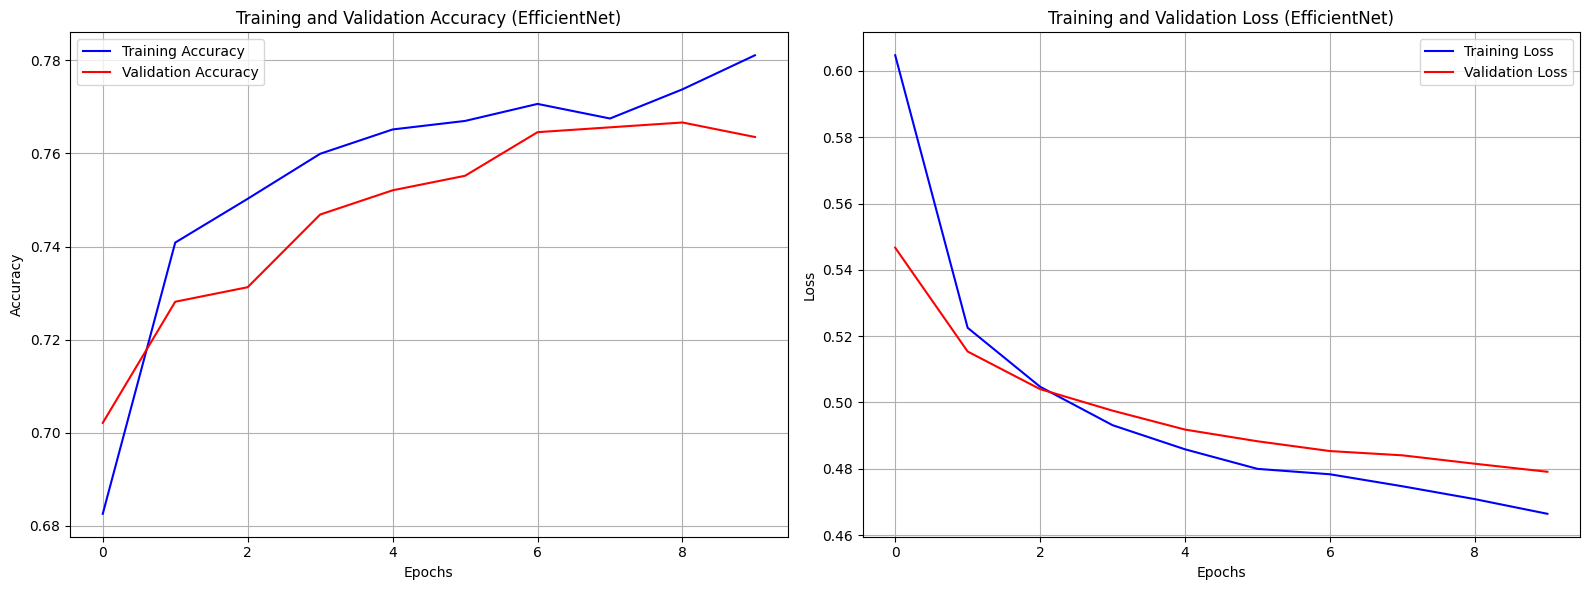

In [45]:
plot_training_history(history_efficient, "EfficientNet")

In [65]:
y_pred = model_efficient.predict(test_dataset_resnet)

test_data, test_labels = get_data_and_labels(test_dataset_resnet)

75/75 [==============================] - 10s 135ms/step


c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [64]:
y_pred, test_labels

(array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 1, 1], dtype=int64))

In [61]:
# y_pred = np.argmax(y_pred, axis=1)
# test_labels = np.argmax(test_labels, axis=1)

accuracy_score(test_labels, y_pred)

0.735

In [66]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming y_pred is a probability array from model.predict()
pred_probs = y_pred  # Store raw probabilities before argmax
y_pred_labels = np.argmax(y_pred, axis=1)  # Get predicted class indices
test_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to class indices

misclassified = []

for i in range(len(y_pred_labels)):
    if y_pred_labels[i] != test_labels[i]:  # Check for misclassification
        misclassified.append((i, test_labels[i], y_pred_labels[i], pred_probs[i]))

# Print misclassified examples
for idx, true_label, pred_label, prob in misclassified:
    print(f"Index: {idx}, True: {true_label}, Predicted: {pred_label}, Probabilities: {prob}")


Index: 5, True: 1, Predicted: 0, Probabilities: [0.7810342  0.21896578]
Index: 9, True: 1, Predicted: 0, Probabilities: [0.9404638  0.05953617]
Index: 11, True: 0, Predicted: 1, Probabilities: [0.35384354 0.64615643]
Index: 14, True: 1, Predicted: 0, Probabilities: [0.53681415 0.46318588]
Index: 16, True: 1, Predicted: 0, Probabilities: [0.72574776 0.27425218]
Index: 17, True: 0, Predicted: 1, Probabilities: [0.3402539  0.65974605]
Index: 23, True: 1, Predicted: 0, Probabilities: [0.8667346 0.1332654]
Index: 27, True: 1, Predicted: 0, Probabilities: [0.6667352  0.33326483]
Index: 30, True: 1, Predicted: 0, Probabilities: [0.800076   0.19992398]
Index: 31, True: 1, Predicted: 0, Probabilities: [0.6319654  0.36803463]
Index: 33, True: 1, Predicted: 0, Probabilities: [0.64151394 0.35848603]
Index: 36, True: 0, Predicted: 1, Probabilities: [0.41238943 0.5876106 ]
Index: 41, True: 0, Predicted: 1, Probabilities: [0.49867725 0.50132275]
Index: 46, True: 1, Predicted: 0, Probabilities: [0.714

In [70]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

# Load a pre-trained model (Example: ResNet)
model = models.resnet50(pretrained=True)
model.eval()

# Load and preprocess image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

#img_path = "your_image.jpg"
image = preprocess_image(image_dir+"TCImages/TC001_39.png")

# Get feature maps from the last convolutional layer
gradients = None
def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Hook to last conv layer
target_layer = model.layer4[2].conv3
target_layer.register_backward_hook(save_gradient)

# Forward pass
output = model(image)
class_idx = output.argmax().item()  # Predicted class

# Backward pass
model.zero_grad()
output[0, class_idx].backward()

# Compute Grad-CAM
weights = torch.mean(gradients, dim=[1, 2], keepdim=True)
activation = target_layer(image).detach()
grad_cam = torch.sum(weights * activation, dim=1).squeeze().numpy()

# Normalize Grad-CAM
grad_cam = np.maximum(grad_cam, 0)
grad_cam = cv2.resize(grad_cam, (224, 224))
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

# Overlay on original image
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


RuntimeError: Given groups=1, weight of size [2048, 512, 1, 1], expected input[1, 3, 224, 224] to have 512 channels, but got 3 channels instead

<h1> Majority voter </h1>

In [ ]:
combined_dataset_cnn = load_dataset("combined_dataset_cnn")

In [ ]:
#model_pca_keras = KerasClassifierCompatible(build_fn=create_model_pca, verbose=0, input_shape=(200,))



In [ ]:
model_cnn_keras = KerasClassifierCompatible(model=create_model_cnn, verbose=1)
y_train_pred_cnn = cross_val_predict(model_cnn_keras, train_data_cnn, train_labels_cnn , cv=3)

In [ ]:
# Define hyperparameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Set up GridSearchCV
# grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)
# print(f"Best parameters for RF: {grid_search_rf.best_params_}")


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# X_train, y_train = get_data_and_labels(train_dataset_cnn)

# if X_train.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
#     X_train = X_train.reshape(X_train.shape[0], -1)

# # Define hyperparameter grid for SVM
# param_grid_svc = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
# }

# # Set up GridSearchCV
# grid_search_svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, cv=2, n_jobs=-1)
# grid_search_svc.fit(X_train, y_train)
# print(f"Best parameters for SVC: {grid_search_svc.best_params_}")


In [ ]:
# Assuming `get_data_and_labels(train_dataset_cnn)` returns (X, y)
X_train, y_train = get_data_and_labels(train_dataset_cnn)
y_train = np.argmax(y_train, axis=1)  # Convert one-hot labels to categorical

# If X_train is image data (e.g., shape (num_samples, height, width, channels)), flatten it
if X_train.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = X_train.reshape(X_train.shape[0], -1)

# Define voting classifier with RandomForest and SVM
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500 )),
        ('svc', SVC(random_state=42, probability=True)),
        #('cnn', model_cnn_keras)
    ],
    voting='soft'
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

In [ ]:
test_dataset = test_dataset_cnn.map(one_hot_encode)

In [ ]:
X_test, y_test = get_data_and_labels(test_dataset)

if X_test.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

voting_clf.score(X_test, y_test_labels)

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test_labels))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the Keras model
def create_keras_model():
    model = Sequential([
        Dense(16, activation="relu", input_shape=(2,)),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create a patched KerasClassifier
class KerasClassifierCompatible(KerasClassifier, BaseEstimator, ClassifierMixin):
    def __sklearn_tags__(self):
        return {
            "estimator_type": "classifier",
            "requires_positive_X": False,
            "no_validation": True,
        }

# Wrap the Keras model
model_keras = KerasClassifierCompatible(build_fn=create_keras_model, verbose=0)

# Create dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
y = y.astype(int)  # Ensure labels are integers
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Use VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('keras', model_keras),
    ],
    voting='hard'
)

# Train and evaluate
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


<h1> Classifying severity of autism </h1>

In [ ]:
severity_data, severity_labels, severity_metadata_features = match_cars_with_images_json(image_dir, metadata_list)

In [ ]:
severity_data, severity_labels = preprocess_dataset(severity_data, severity_labels, target_size=(100,100), color=False)

In [ ]:
severity_dataset = create_dataset(severity_data, severity_labels)

In [ ]:
X,y = get_data_and_labels(severity_dataset)

In [ ]:
severity_dataset.take(1)

In [ ]:
import numpy as np
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

if X.ndim > 2:  # If it's 3D or 4D (images), reshape to 2D
    X = X.reshape(X.shape[0], -1)

# Encode labels numerically
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear')
log_reg.fit(X_train, y_train)

# Evaluate the model
accuracy = log_reg.score(X_test, y_test)
print(f'Logistic Regression Accuracy: {accuracy:.4f}')

In [ ]:
from sklearn.metrics import accuracy_score

# Define individual classifiers
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

# Create a majority voting classifier
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('rf_clf', rf_clf),
    ('svm_clf', svm_clf)
], voting='hard')  # 'hard' means majority voting

# Train the model
voting_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Majority Voting Classifier Accuracy: {accuracy:.4f}')

<h2> Severity PCA </h2>

In [ ]:
#THE DATA IS NOT AUGMENTED!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
augmented_severity_data, augmented_severity_labels = augment_multiple_times(severity_data, severity_labels, augmentations=10, batch_size=32)

In [ ]:
severity_combined_data = np.concatenate((severity_data, augmented_severity_data), axis=0)
severity_combined_labels = np.concatenate((severity_labels, augmented_severity_labels), axis=0)

In [ ]:
severity_data_pca, severity_labels_pca, severity_pca_model = apply_pca(severity_combined_data, severity_combined_labels, n_components=400)

In [ ]:
severity_dataset_pca = create_dataset(severity_data_pca, severity_labels_pca)

In [ ]:
train_dataset_severity_pca, test_dataset_severity_pca = tf.keras.utils.split_dataset(
    severity_dataset_pca,
    left_size=0.8,
    shuffle=True,
    seed=42
)

train_dataset_severity_pca, val_dataset_severity_pca = tf.keras.utils.split_dataset(
    train_dataset_severity_pca,
    left_size=0.8,
    shuffle=True,
    seed=42
)

In [ ]:
# Initialize model
severity_model_pca = create_model_pca(input_shape=(400,),n_classes=4)

# Display model summary
severity_model_pca.summary()

In [ ]:
train_dataset_severity_pca = train_dataset_severity_pca.map(one_hot_encode_severity)

val_dataset_severity_pca= val_dataset_severity_pca.map(one_hot_encode_severity)

In [ ]:
reset_weights(severity_model_pca)

history_severity_pca = severity_model_pca.fit(train_dataset_severity_pca, batch_size=batch_size, epochs=40, 
                                     validation_data=val_dataset_severity_pca, callbacks=[early_stopping, reduce_lr])

In [ ]:
plot_training_history(history_severity_pca, "Severity PCA")

In [ ]:
test_dataset_severity_pca= test_dataset_severity_pca.map(one_hot_encode_severity)

In [ ]:
# Generate predictions from the model
predictions = np.argmax(severity_model_pca.predict(test_dataset_severity_pca), axis=-1)

# Extract true labels from the test dataset
true_labels = []
for _, labels in test_dataset_severity_pca:
    true_labels.extend(np.argmax(labels, axis=-1))  # Convert one-hot to class indices
    
true_labels = np.array(true_labels)  # Convert list to numpy array

# Calculate overall accuracy
overall_accuracy = np.mean(predictions == true_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")
